# PROJET 4 : CONSTRUISEZ UN MODELE DE SCORING

## DESCRIPTION DU JEU DE DONNEES

### Importer les librairies 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import os
import glob
import pickle


from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn import preprocessing

from imblearn.pipeline import make_pipeline, Pipeline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.python.client import device_lib 

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import where
from sklearn.preprocessing import MinMaxScaler


from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer

### Utiliser les données d'apprentissage

In [2]:
missing_values = ["n/a", "na", "--", "XNA"]

In [3]:
app_train = pd.read_csv('../P4_KRAIRI_Jaoid/input/application_train.csv', na_values= missing_values)
print('Nombre de lignes et de colonnes: ', app_train.shape)
app_train.head()

Nombre de lignes et de colonnes:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Les données d'apprentissage comportent 307511 observations (chacune un prêt distinct) et 122 caractéristiques (variables) dont la CIBLE (étiquette que nous voulons prédire).

### Utiliser les données de test

In [4]:
app_test = pd.read_csv('../P4_KRAIRI_Jaoid/input/application_test.csv', na_values= missing_values)
print("Nombre de lignes et de colonnes d'essai: ", app_test.shape)
app_test.head()

Nombre de lignes et de colonnes d'essai:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


L’ensemble de tests est considérablement plus petit (de 307511 à 48744 lignes) et n’a pas de colonne variable cible (de 122 à 121 colonnes).

### Analyse des valeurs manquantes données d'apprentissage

<AxesSubplot:>

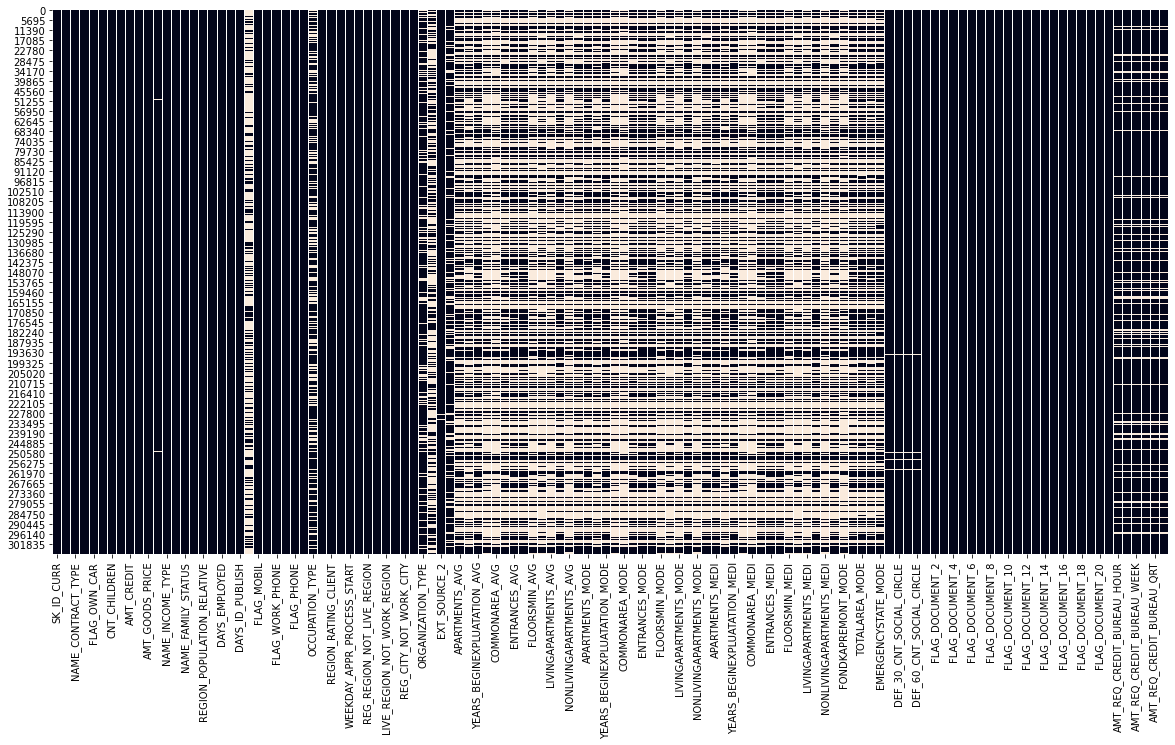

In [5]:
plt.figure(figsize=(20,10))
sb.heatmap(app_train.isna(), cbar=False)

Ce graphique me permet de voir un grand nombre de valeurs manquantes qui apparaissent en jaune.
Une synthèse des données manquantes un peu confuse du fait du grand nombre de variables, mais il se dégage un premier constat qui montre que les NaN sont plus fortement présentent sur les caractéristiques des habitats (et non sur les crédits), comme l'atteste le TOP 10 ci-après 

### Utiliser les autres données

In [6]:
bureau = pd.read_csv('../P4_KRAIRI_Jaoid/input/bureau.csv', na_values= missing_values)
bureau_balance = pd.read_csv('../P4_KRAIRI_Jaoid/input/bureau_balance.csv', na_values= missing_values)
credit_card_balance = pd.read_csv('../P4_KRAIRI_Jaoid/input/credit_card_balance.csv', na_values= missing_values)
installments_payments = pd.read_csv('../P4_KRAIRI_Jaoid/input/installments_payments.csv', na_values= missing_values)
POS_CASH_balance = pd.read_csv('../P4_KRAIRI_Jaoid/input/POS_CASH_balance.csv', na_values= missing_values)
previous_application = pd.read_csv('../P4_KRAIRI_Jaoid/input/previous_application.csv', na_values= missing_values)

### Nombre de chaque type de colonne données d'apprentissage

In [7]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

Nous constatons qu'il y a 106 variables quantitatives dite numérique et 16 variables qualitatives dite catégoriques dans les données d'apprentissage. 

In [8]:
app_train.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

La plupart des variables catégoriques ont un nombre relativement faible d’entrées uniques.

### Outliers, valeurs atypiques, anormales

#### Visualiser 'DAYS_BIRTH'  age client en année app_train

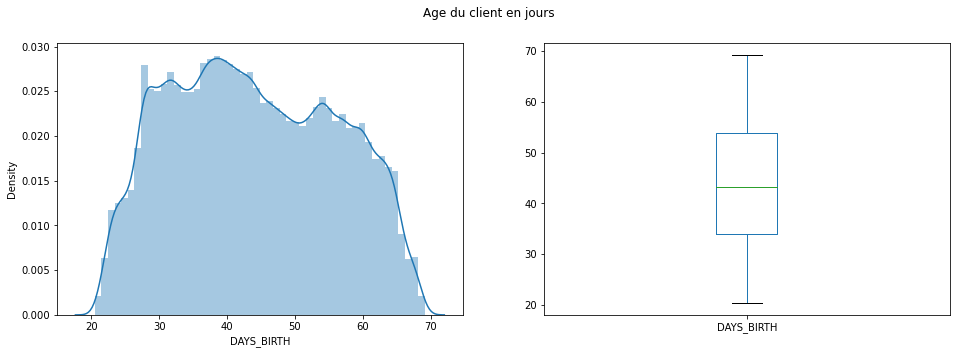

In [9]:
plt.figure(1)
plt.subplot(121)
sb.distplot(app_train['DAYS_BIRTH']/ -365)

plt.subplot(122)
(app_train['DAYS_BIRTH']/ -365).plot.box(figsize=(16,5))
plt.suptitle('Age du client en jours')
plt.show()

On constate sur le diagramme à moustache une idée sur l'étalement des âges des clients par ans, on y constate aucun outlier. On constate aussi que la distribution suit bien la courbe des âges des clients sur app_train.

#### Visualiser 'AMT_ANNUITY' le salaire annuel des clients sur app_train

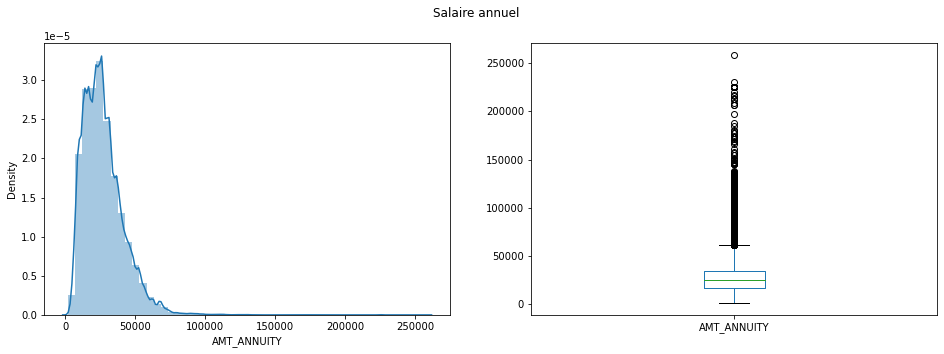

In [10]:
plt.figure(1)
plt.subplot(121)
sb.distplot(app_train['AMT_ANNUITY'])

plt.subplot(122)
app_train['AMT_ANNUITY'].plot.box(figsize=(16,5))
plt.suptitle('Salaire annuel')
plt.show()

On constate sur le diagramme à moustache une idée sur l'étalement des salaires annuels des clients, on y constate un gand nombre d'outlier qui sont à mon sens atypique car elles sont probablement vrai. On constate aussi que la distribution suit bien la courbe des salaires annuels sur app_train.

#### Visualiser 'DAYS_EMPLOYED' le nombre de jours d'emploi des clients sur app_train

In [11]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Text(0.5, 0, "Jours d'emploi")

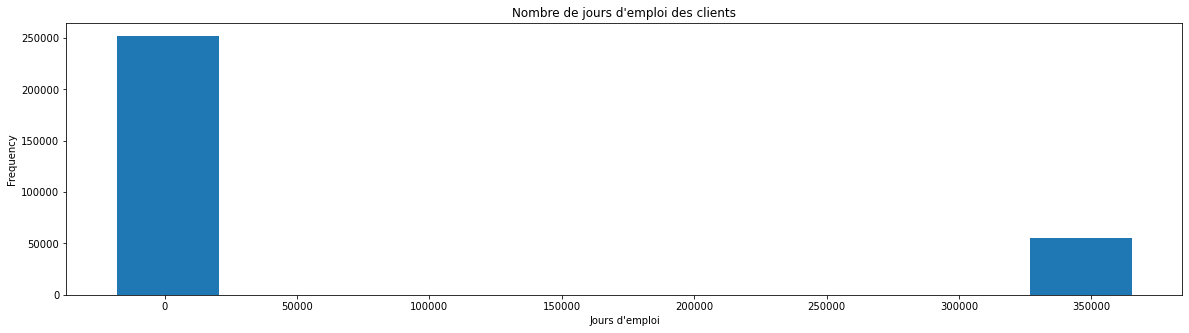

In [12]:
app_train['DAYS_EMPLOYED'].plot.hist(title = "Nombre de jours d'emploi des clients", figsize=(20,5));
plt.xlabel("Jours d'emploi")

Je constate que ces données ne sont pas "normales" au sens où le Max. représente 1000 années (365243/365j). Est-ce un individu isolé? Plusieurs individus de l'échantillon?

In [13]:
print("%0.0f valeurs avec 365243 jours d'emploi dans la variable DAYS_EMPLOYED des données train" % 
      len(app_train[app_train['DAYS_EMPLOYED'] == 365243]))
print("%0.0f valueurs total dans la variable DAYS_EMPLOYED des données train" % app_train.shape[0])
print("***********************")
print("%0.0f valeurs avec 365243 jours d'emploi dans la variable DAYS_EMPLOYED des données test" % 
      len(app_test[app_test['DAYS_EMPLOYED'] == 365243]))
print("%0.0f valueurs total dans la variable DAYS_EMPLOYED des données test" % app_test.shape[0])

55374 valeurs avec 365243 jours d'emploi dans la variable DAYS_EMPLOYED des données train
307511 valueurs total dans la variable DAYS_EMPLOYED des données train
***********************
9274 valeurs avec 365243 jours d'emploi dans la variable DAYS_EMPLOYED des données test
48744 valueurs total dans la variable DAYS_EMPLOYED des données test


##### Créer une colonne d’indicateur de valeurs aberrantes

In [14]:
app_train['DAYS_EMPLOYED_OUTLIERS'] = app_train["DAYS_EMPLOYED"] == 365243
app_test['DAYS_EMPLOYED_OUTLIERS'] = app_test["DAYS_EMPLOYED"] == 365243

##### Remplacer les valeurs aberrantes par nan

In [15]:
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

##### Afficher l'histogramme

Text(0.5, 0, "Jours d'emploi")

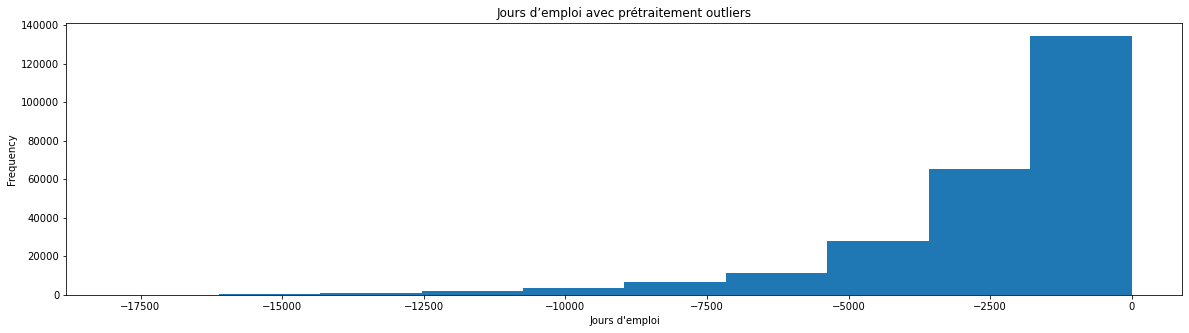

In [16]:
app_train['DAYS_EMPLOYED'].plot.hist(title ='Jours d’emploi avec prétraitement outliers', figsize=(20,5))
plt.xlabel("Jours d'emploi")

On constate que nos valeurs aberrantes n'est pas pris en compte dans notre histogramme

### Faciliter par ces fonctions l'analyse des principales variables

Il est important de se focaliser sur les principales features pouvant être explicatives. Ici l'idée n'est pas de tout analyser en univarié ou multivarié, mais simplement d'avoir une image des points métiers qui aident à orienter nos décisions dans la "prise de risque" à l'attribution d'un crédit.

In [17]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sb.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

In [18]:
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sb.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Pourcentage pour une valeur '1' TARGET")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

#### Distribution du type de prêts contractés + comparatif avec le pourcentage des prêts avec la valeur TARGET=1 (prêt non remborsé à temps)

                                   -------------------------------------------------------


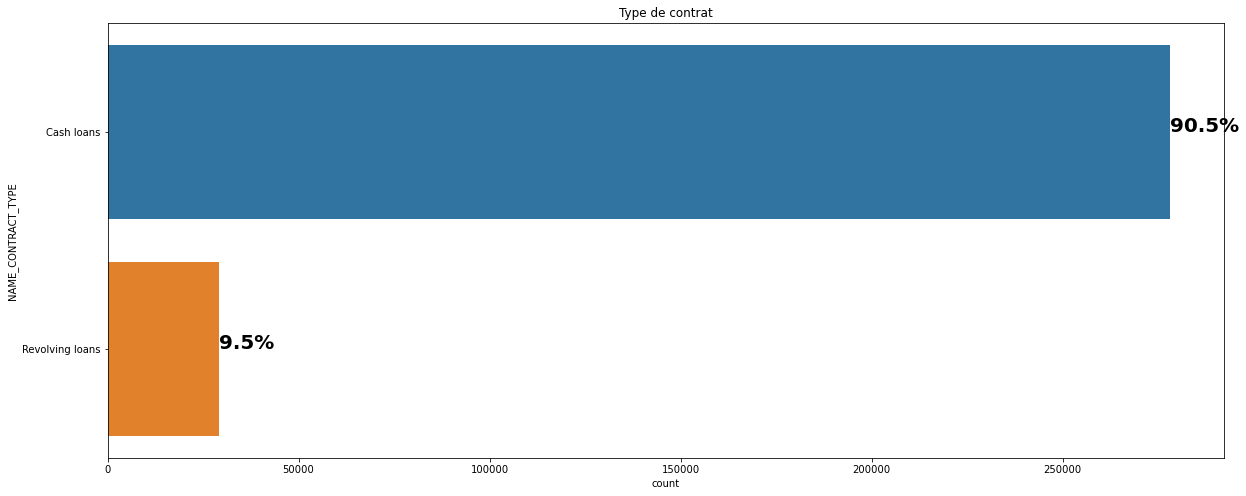

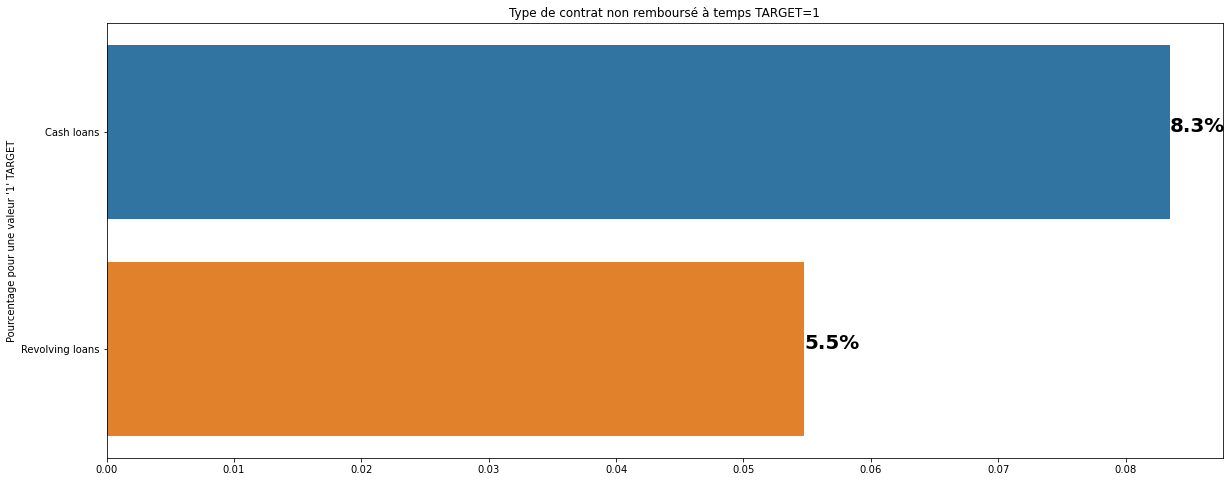

In [19]:
plot_stat(app_train, 'NAME_CONTRACT_TYPE',"Type de contrat")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'NAME_CONTRACT_TYPE',"Type de contrat non remboursé à temps TARGET=1")

On constate que les prêts renouvelables ne représentent qu'une petite fraction (10%) du nombre total de prêts; dans le même temps, un plus grand nombre de crédits renouvelables, par rapport à leur fréquence, ne sont pas remboursés à temps.

#### Distribution H/F clients, mais aussi le pourcentage des prêts (par sexe du client) avec la valeur TARGET =1 (prêt non remborsé à temps).

                                   -------------------------------------------------------


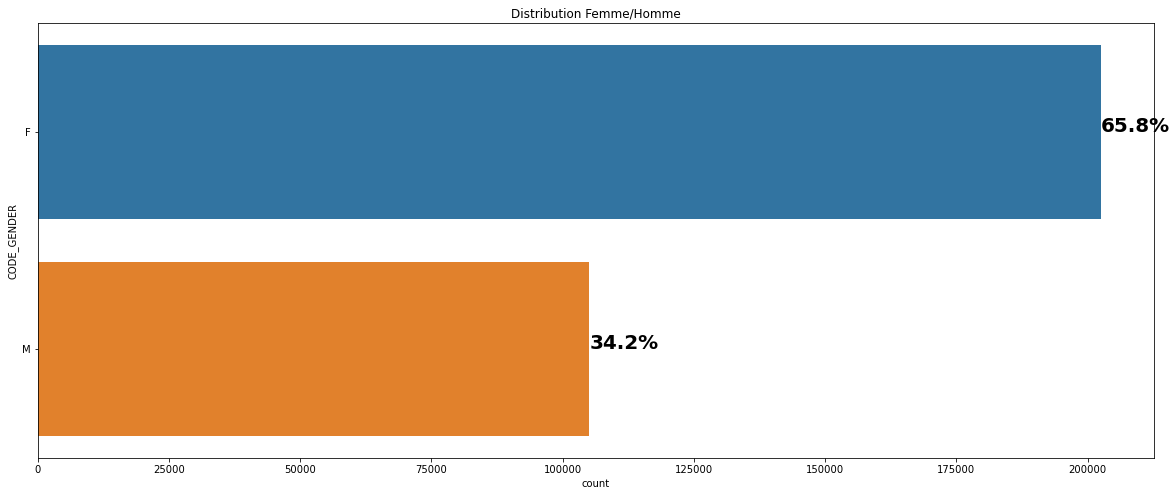

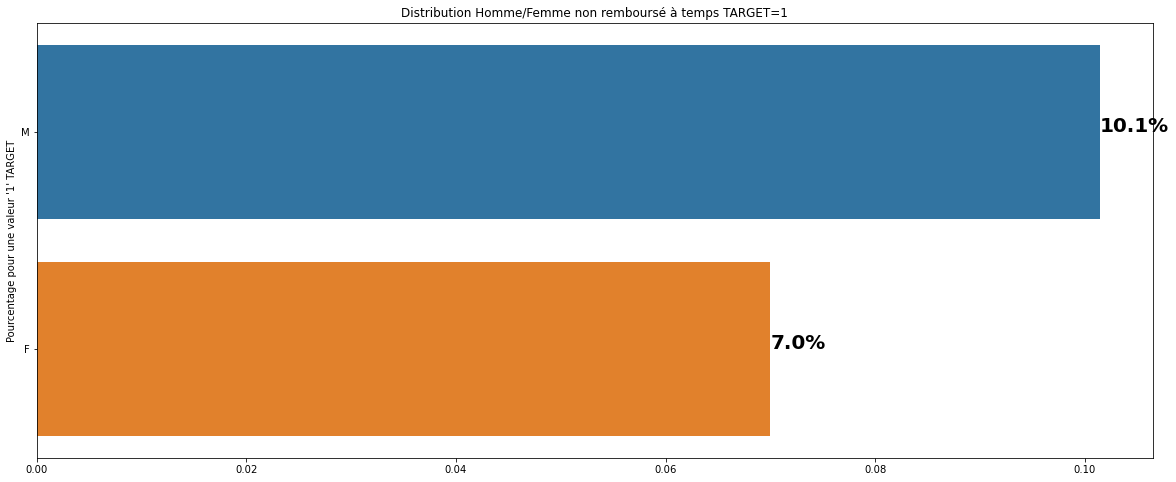

In [20]:
plot_stat(app_train, 'CODE_GENDER',"Distribution Femme/Homme")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'CODE_GENDER',"Distribution Homme/Femme non remboursé à temps TARGET=1")

On constate que le nombre de clients féminins est presque le double du nombre de clients masculins. En ce qui concerne le pourcentage de crédits en souffrance, les hommes ont plus de chances de ne pas rembourser leurs prêts (10%), comparativement aux femmes (7%).

#### Distribution d'un impact possible entre les clients propriétaire d'un véhicule et ceux qui ne le sont pas

                                   -------------------------------------------------------


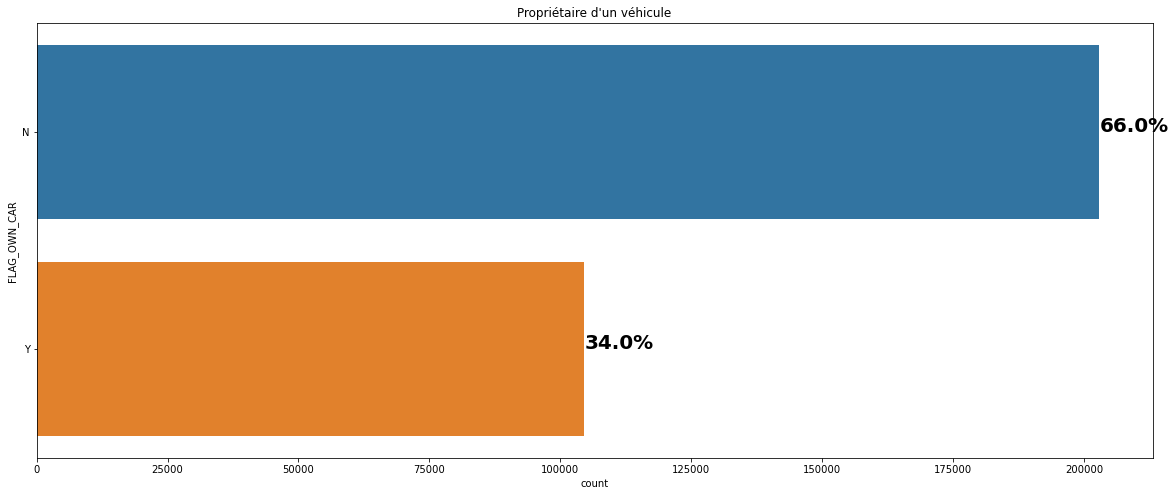

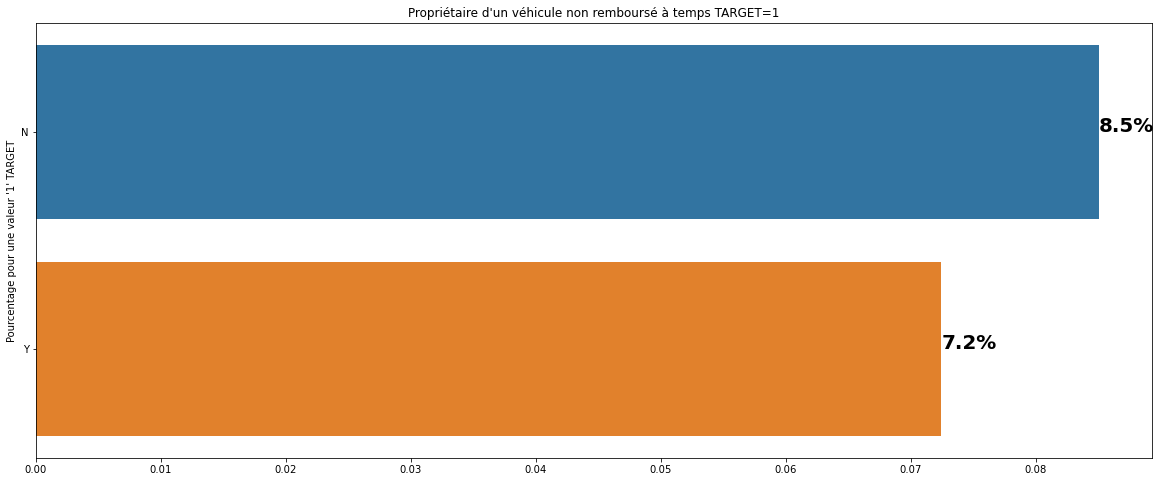

In [21]:
plot_stat(app_train, 'FLAG_OWN_CAR',"Propriétaire d'un véhicule")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'FLAG_OWN_CAR',"Propriétaire d'un véhicule non remboursé à temps TARGET=1")

On constate que les deux catégories (propriétaire ou non) ont des taux de non-remboursement d'environ 8%

#### Distribution d'un impact possible entre les statuts familiales des clients

                                   -------------------------------------------------------


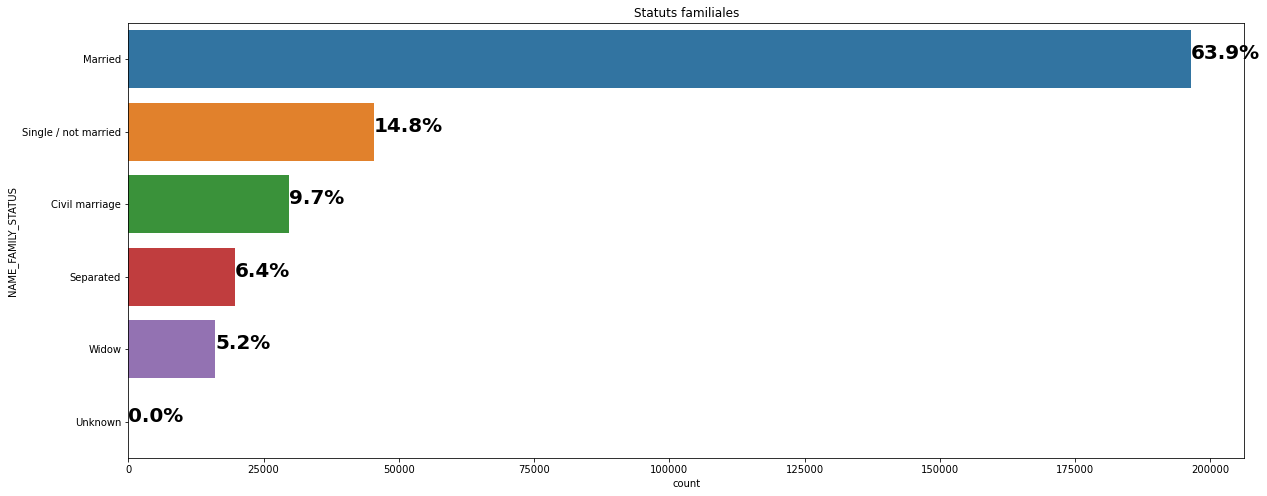

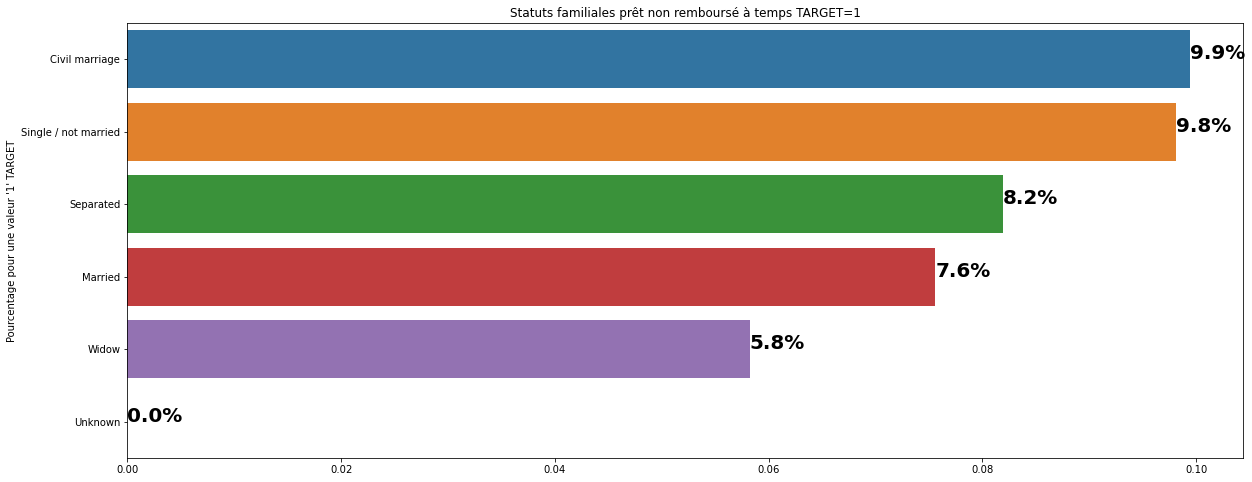

In [22]:
plot_stat(app_train, 'NAME_FAMILY_STATUS',"Statuts familiales")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'NAME_FAMILY_STATUS',"Statuts familiales prêt non remboursé à temps TARGET=1")

On constate que la plupart des clients sont mariés, suivis des célibataires / non mariés et des mariages civils.
En termes de pourcentage de non-remboursement du prêt, le mariage civil a le pourcentage le plus élevé de non-remboursement (10%), la veuve étant le plus bas (à l'exception de l'inconnu).

#### Distribution d'un impact possible entre le type de revenue des clients

                                   -------------------------------------------------------


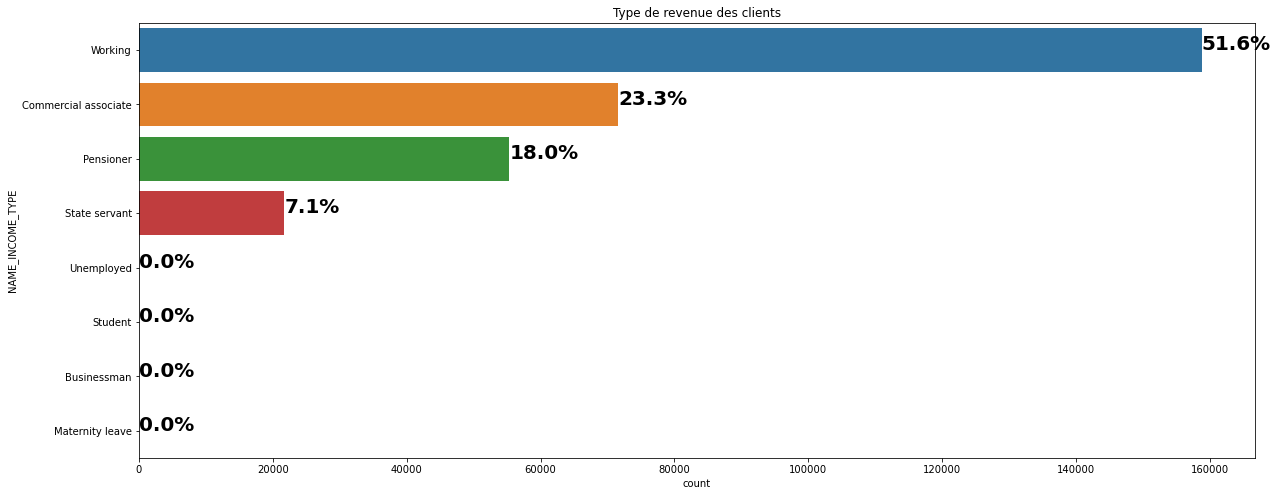

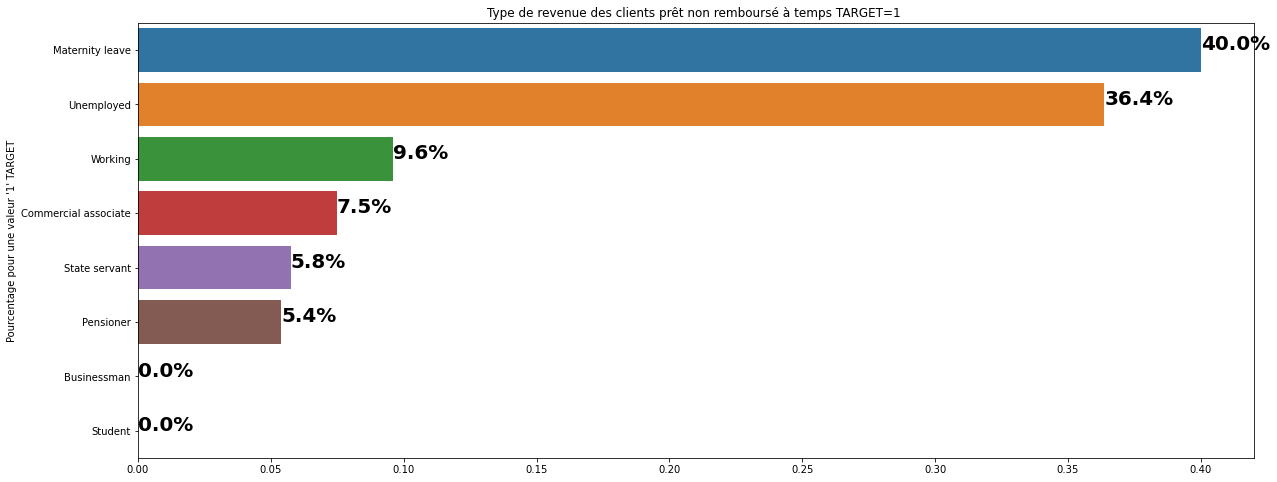

In [23]:
plot_stat(app_train, 'NAME_INCOME_TYPE',"Type de revenue des clients")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'NAME_INCOME_TYPE',"Type de revenue des clients prêt non remboursé à temps TARGET=1 ")

On constate que la plupart des demandeurs de prêts sont des revenus du travail, suivis par un associé commercial, un retraité et un fonctionnaire.
Les demandeurs avec le type de revenu Congé de maternité ont un ratio de près de 40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à la moyenne de 10% pour ne pas rembourser les prêts.

#### Distribution d'un impact possible entre les différents types de métiers

                                   -------------------------------------------------------


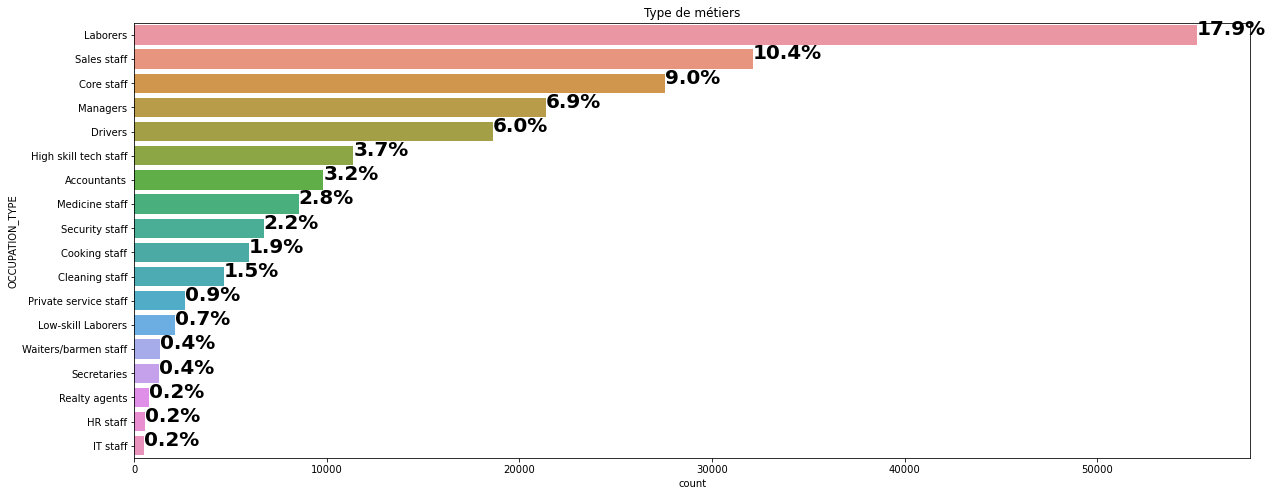

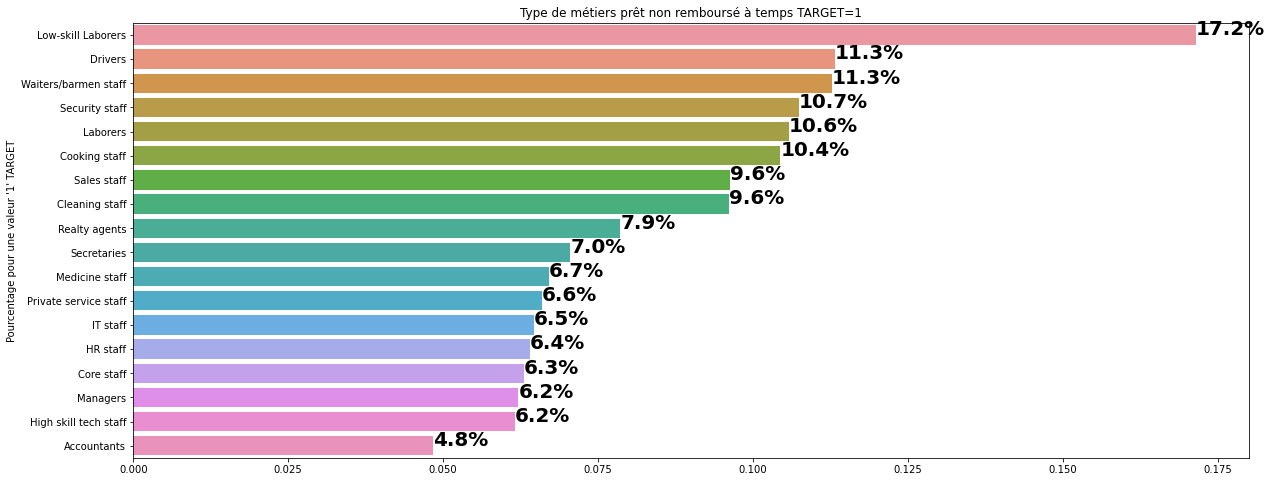

In [24]:
plot_stat(app_train, 'OCCUPATION_TYPE',"Type de métiers")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'OCCUPATION_TYPE',"Type de métiers prêt non remboursé à temps TARGET=1")

On constate que la plupart des prêts sont contractés par des ouvriers, suivis par les vendeurs/commerciaux. Le personnel informatique prend le montant de prêts le plus bas.
La catégorie avec le pourcentage le plus élevé de prêts non remboursés est celle des ouvriers peu qualifiés (plus de 17%), suivis des chauffeurs et des serveurs / barmen, du personnel de sécurité, des ouvriers et du personnel de cuisine.

#### Distribution d'un impact possible entre les niveaux d'éducation scolaire des clients

                                   -------------------------------------------------------


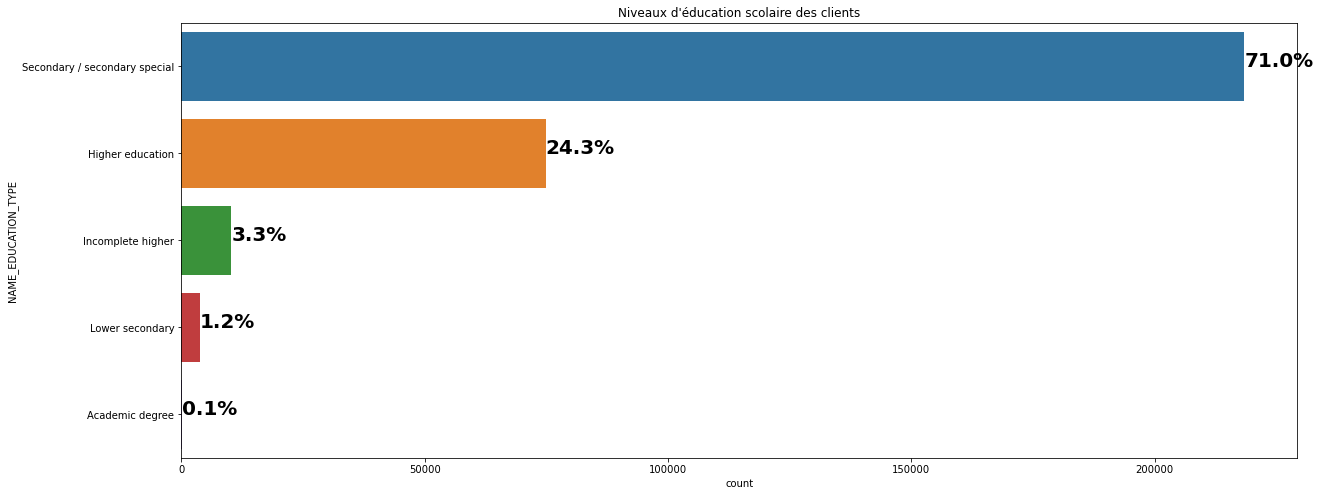

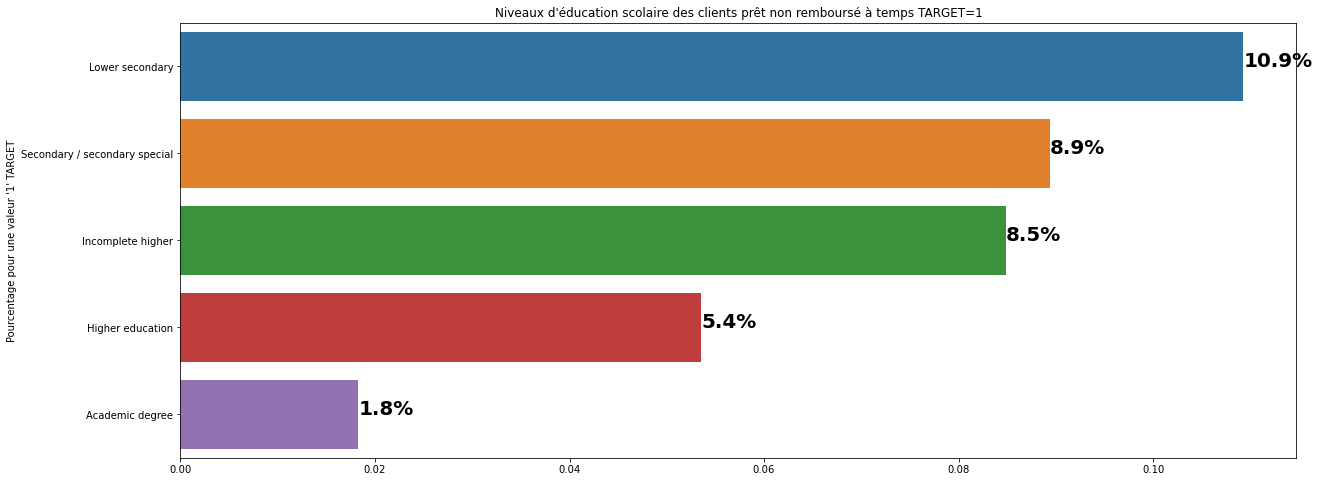

In [25]:
plot_stat(app_train, 'NAME_EDUCATION_TYPE',"Niveaux d'éducation scolaire des clients")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'NAME_EDUCATION_TYPE',"Niveaux d'éducation scolaire des clients prêt non remboursé à temps TARGET=1")

On constate que la majorité des clients ont une éducation dans l'éducation secondaire, suivis des clients avec une éducation supérieure. Un très petit nombre d'emprunteur possède un diplôme universitaire.
La catégorie du premier cycle du secondaire, bien que rare, a le taux le plus élevé de non-remboursement du prêt (11%). Les personnes ayant un diplôme universitaire ont un taux de non-remboursement inférieur à 2%.

#### Distribution d'un impact possible entre les types de logement des clients

                                   -------------------------------------------------------


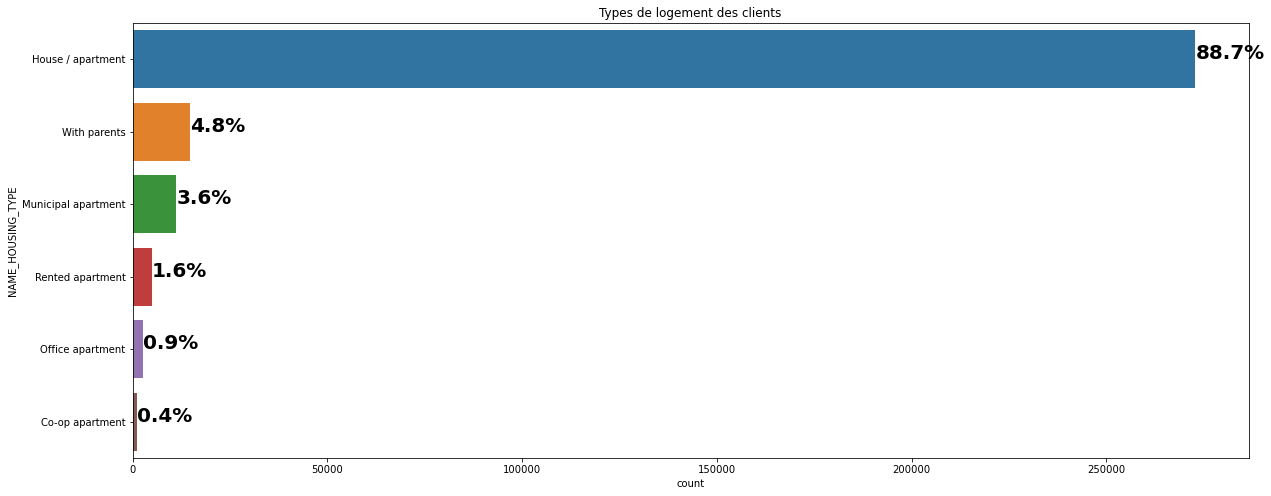

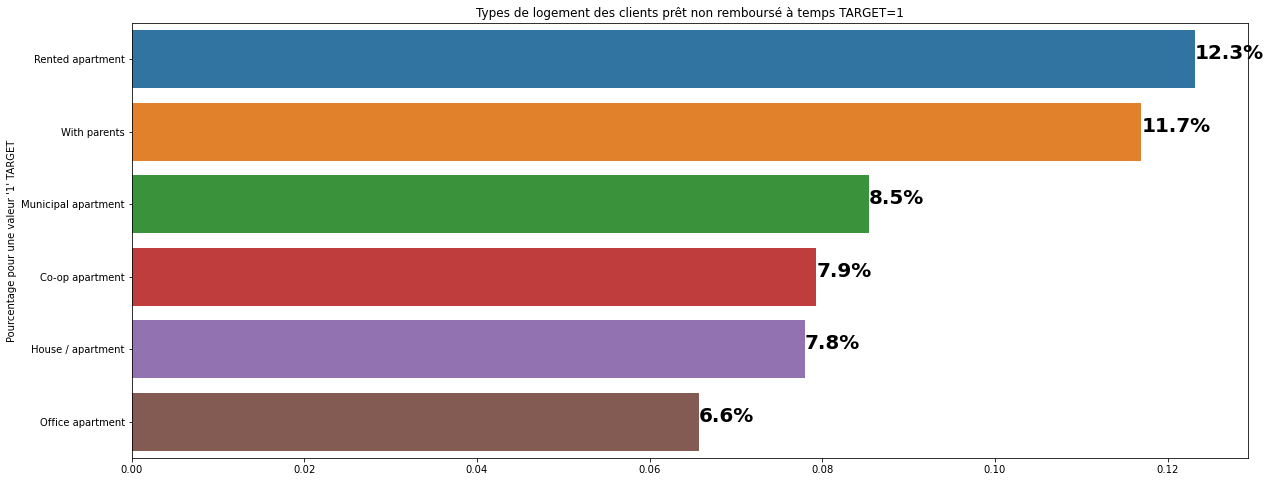

In [26]:
plot_stat(app_train, 'NAME_HOUSING_TYPE',"Types de logement des clients")
print("                                   -------------------------------------------------------")
plot_percent_target1(app_train, 'NAME_HOUSING_TYPE',"Types de logement des clients prêt non remboursé à temps TARGET=1")

On constate que plus de 250 000 demandeurs de crédits vivent en maison ou appartement. Les catégories suivantes, faible pourcentage, représentent une population moins "indépendante".
Dans ces catégories, les loueurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement supérieur à 10%.

#### Répartition des âges en foction TARGET

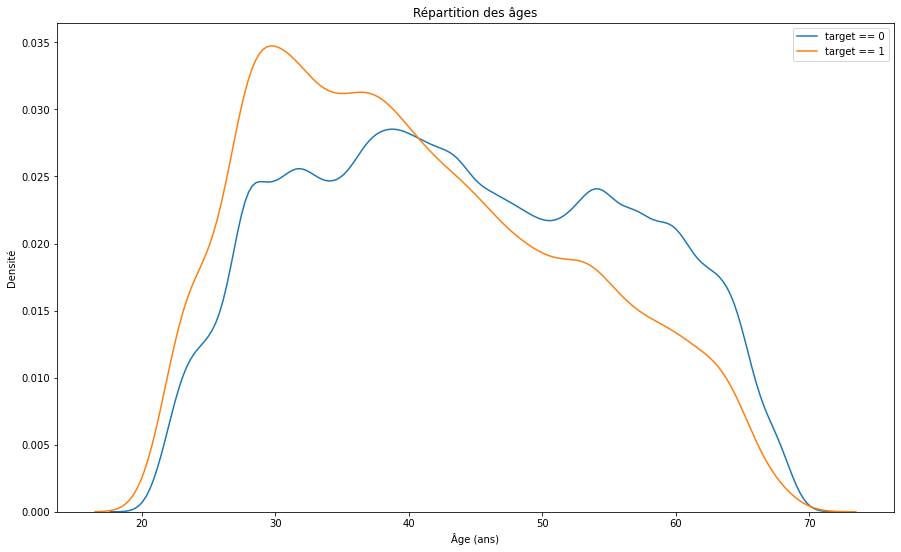

In [27]:
fig = plt.figure(1, figsize=(15, 9))

# Le graphique des prêts qui ont été remboursés à temps
sb.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 'target == 0')

# Le graphique des prêts qui n'ont pas été remboursés à temps
sb.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'target == 1')

# Étiquetage de la distribution
plt.xlabel('Âge (ans)'); plt.ylabel('Densité'); plt.title('Répartition des âges');
plt.legend()

La courbe cible TARGET 1 s'incline vers l'extrémité la plus jeune de la plage. Bien qu'il ne s'agisse pas d'une corrélation significative (coefficient Pearson -0,07), cette variable sera probablement utile dans un modèle d'apprentissage car elle affecte la Target.

#### Faciliter la distribution du tracé par cette fonction

In [28]:
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = app_train.loc[app_train['TARGET'] == 0]
    t1 = app_train.loc[app_train['TARGET'] == 1]

    
    sb.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sb.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()

#### Afficher les différentes distributions

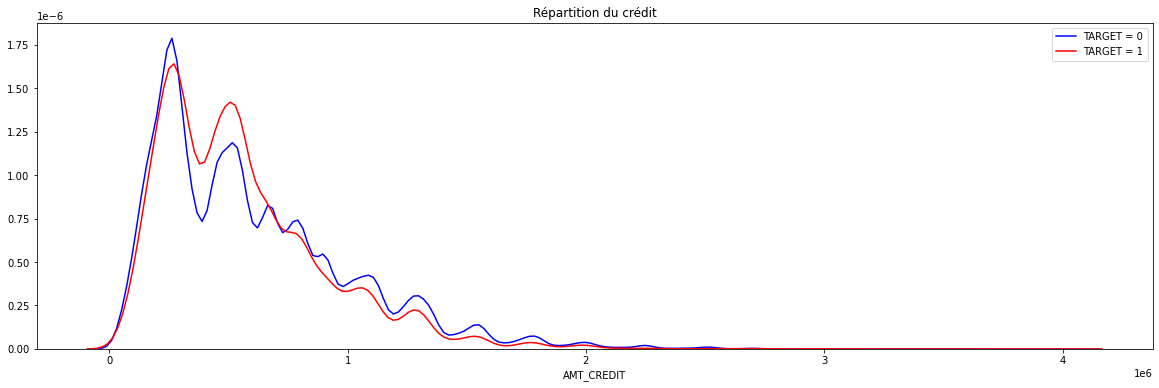

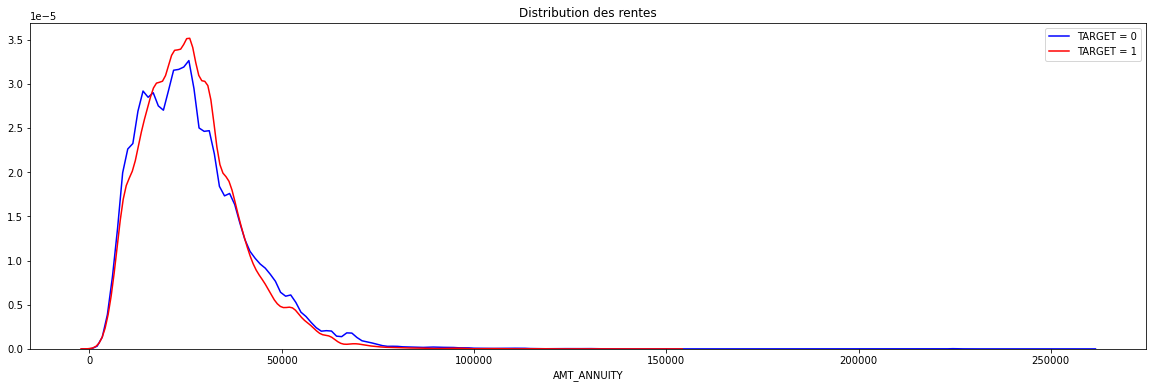

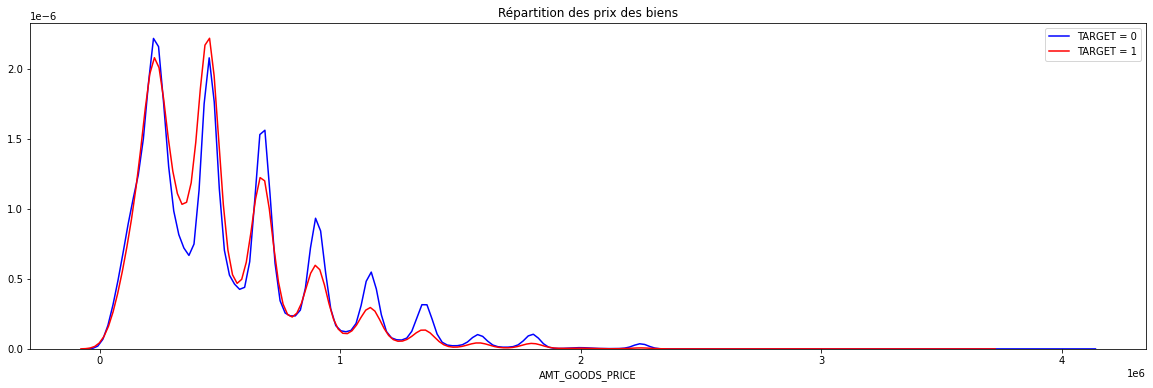

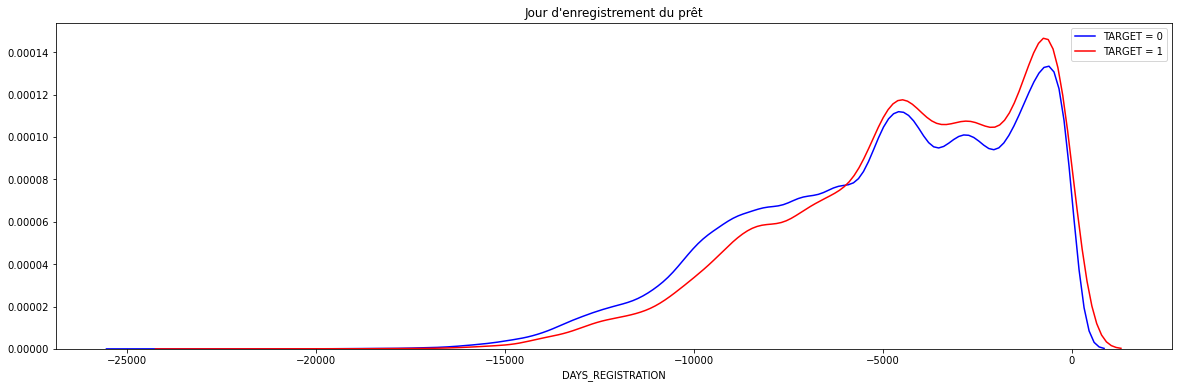

In [29]:
plot_distribution('AMT_CREDIT', "Répartition du crédit")

plot_distribution('AMT_ANNUITY', "Distribution des rentes")

plot_distribution('AMT_GOODS_PRICE', "Répartition des prix des biens")

plot_distribution('DAYS_REGISTRATION', "Jour d'enregistrement du prêt")


### Analyse des données exploratoire bureau

Ce fichier contient tous les crédits antérieurs des clients fournis par d'autres institutions financières qui ont été déclarés au Bureau de crédit (pour les clients qui ont un prêt dans l'échantillon). Pour chaque prêt de l'échantillon, il y a autant de lignes que de nombre de crédits que le client avait au bureau de crédit avant la date de la demande. SK_ID_CURR est la clé reliant les données application_train | test aux données du bureau.
Il est nécessaire de fusionner "application_train" avec "bureau" pour pour pouvoir extraire la part de TARGET == 1.

In [30]:
app_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

#### Distribution d'un impact possible entre la répartition du statut du crédit des clients

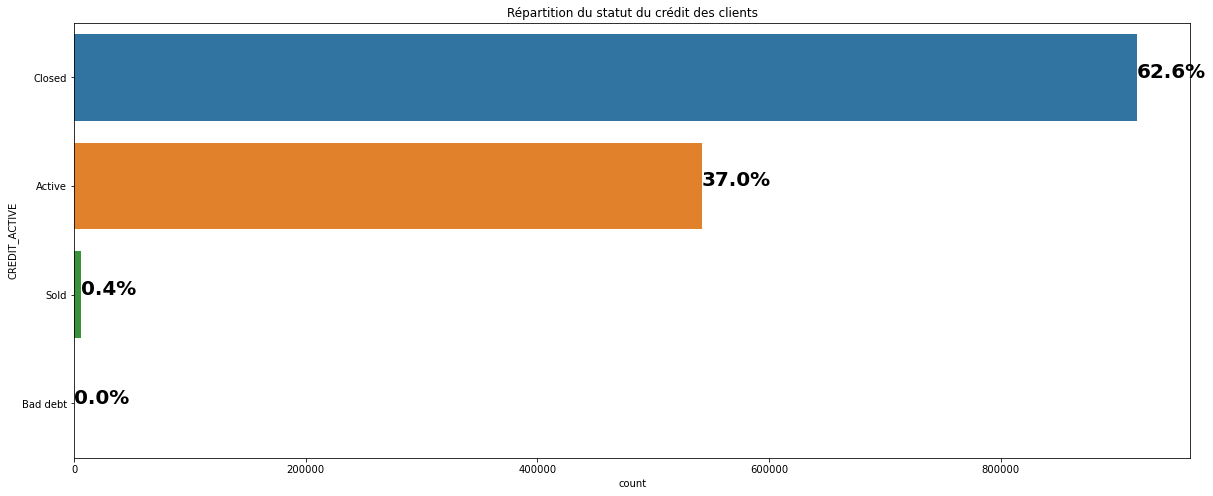

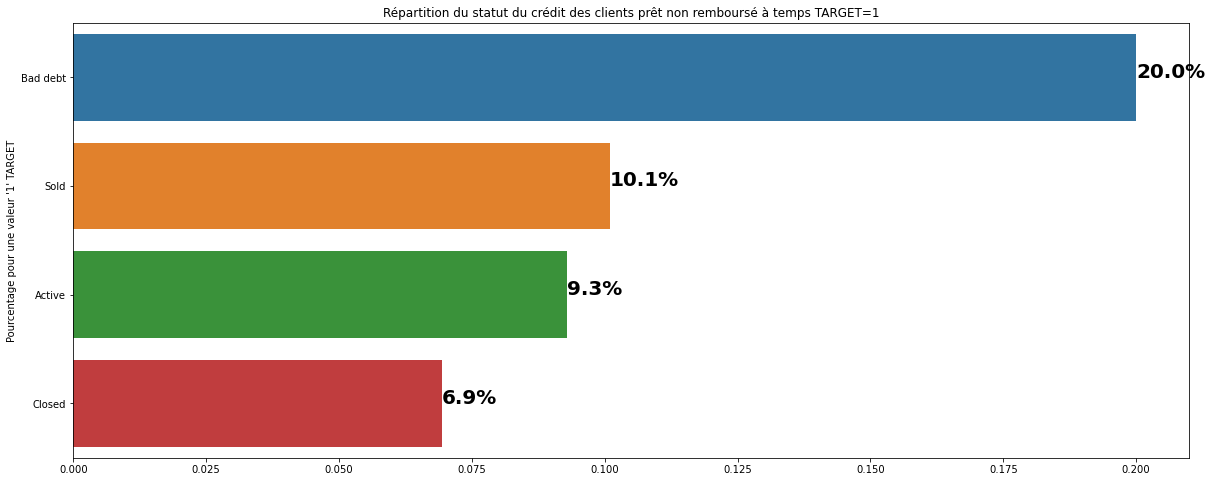

In [31]:
plot_stat(app_bureau_train, 'CREDIT_ACTIVE',"Répartition du statut du crédit des clients")

plot_percent_target1(app_bureau_train, 'CREDIT_ACTIVE',"Répartition du statut du crédit des clients prêt non remboursé à temps TARGET=1")

On constate que la majorité des statuts des clients ont un crédit fermé, suivis des clients avec un crédit actif. Un très petit nombre d'emprunteur possède un crédit vendu.
La catégorie crédit vendu, bien que rare, a le taux le plus élevé de non-remboursement du prêt (10%). Les personnes ayant un crédit actif ont un taux de non-remboursement inférieur à 10% et pour finir les personnes ayant un crédit fermé ont un taux inférieur à 7%.

#### Distribution d'un impact possible entre la distribution des devises de crédit

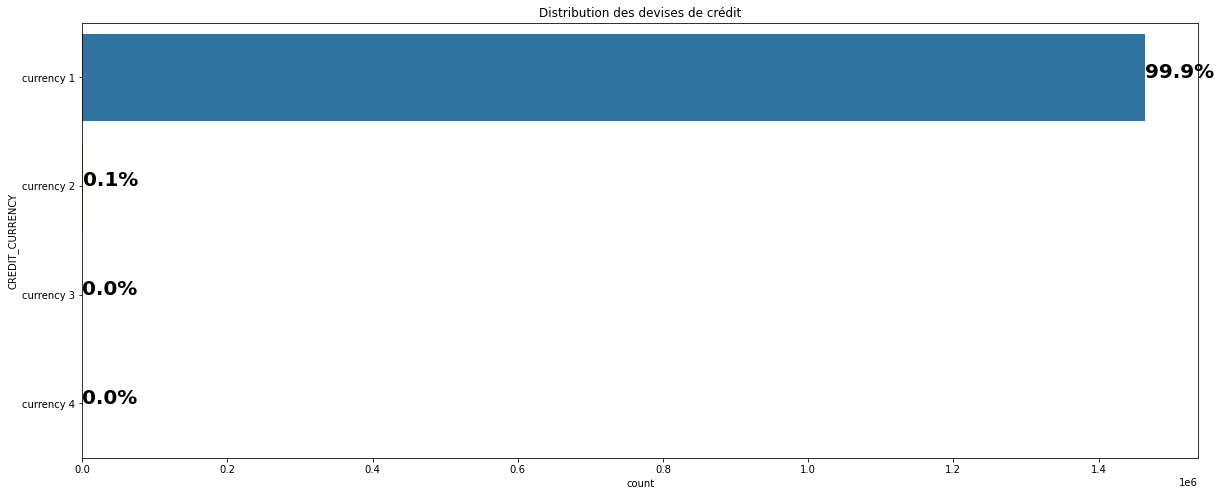

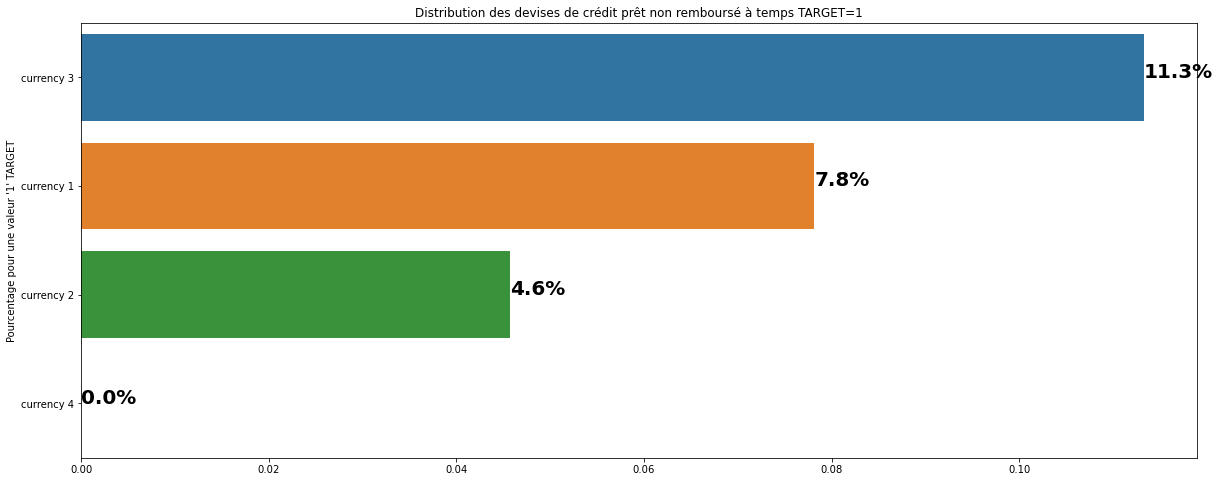

In [32]:
plot_stat(app_bureau_train, 'CREDIT_CURRENCY',"Distribution des devises de crédit")

plot_percent_target1(app_bureau_train, 'CREDIT_CURRENCY',"Distribution des devises de crédit prêt non remboursé à temps TARGET=1")

On constate que la devise la plus utilisé est celle du pays où il réside à près de 100% des client et le prêt non remboursé à temps est inférieur à 12%.

#### Distribution d'un impact possible entre les types de crédit distribuées

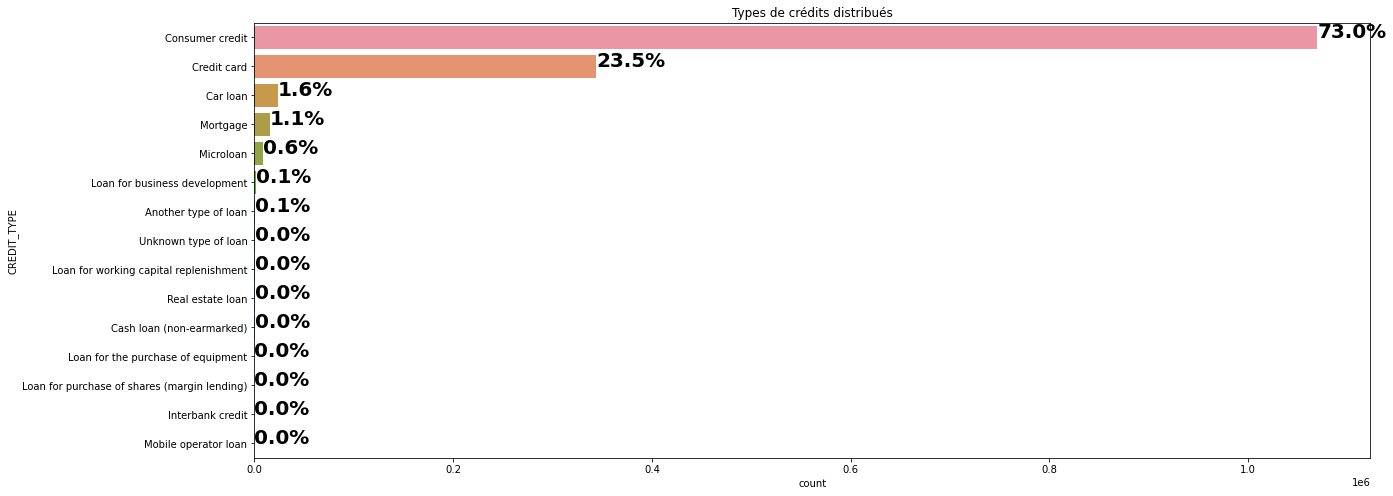

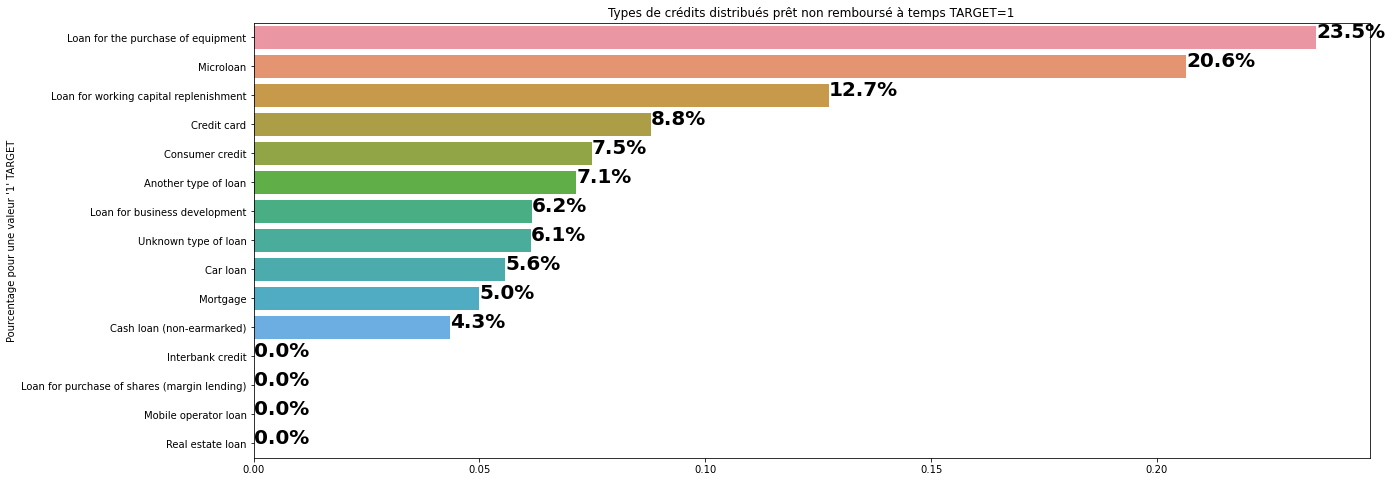

In [33]:
plot_stat(app_bureau_train, 'CREDIT_TYPE',"Types de crédits distribués")

plot_percent_target1(app_bureau_train, 'CREDIT_TYPE',"Types de crédits distribués prêt non remboursé à temps TARGET=1")

On constate que les crédit à la consomation sont majoritaire représentant 73.00 % des clients suivi des carte de crédits à 23.50% et d'autre forme de prêt inférieur à 2%.
La catégorie carte de crédit, bien que représentant 23.50%, a le taux le plus élevé de non-remboursement du prêt inférieur à 9% suivi du prêt à la consomation inférieur à 8%.

### Analyse des données exploratoire previous_application

"previous_application" contient des informations sur toutes les demandes précédentes de crédit immobilier des clients qui ont des prêts dans l'échantillon. Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données. SK_ID_CURR est la clé reliant les données app_train | test aux données previous_application.
Il est nécessaire de fusionner "app_train" avec "previous_application" pour pour pouvoir extraire la part de TARGET == 1.

In [34]:
app_prev_train = app_train.merge(previous_application, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

#### Distribution d'un impact possible entre les types de contrat délivrés

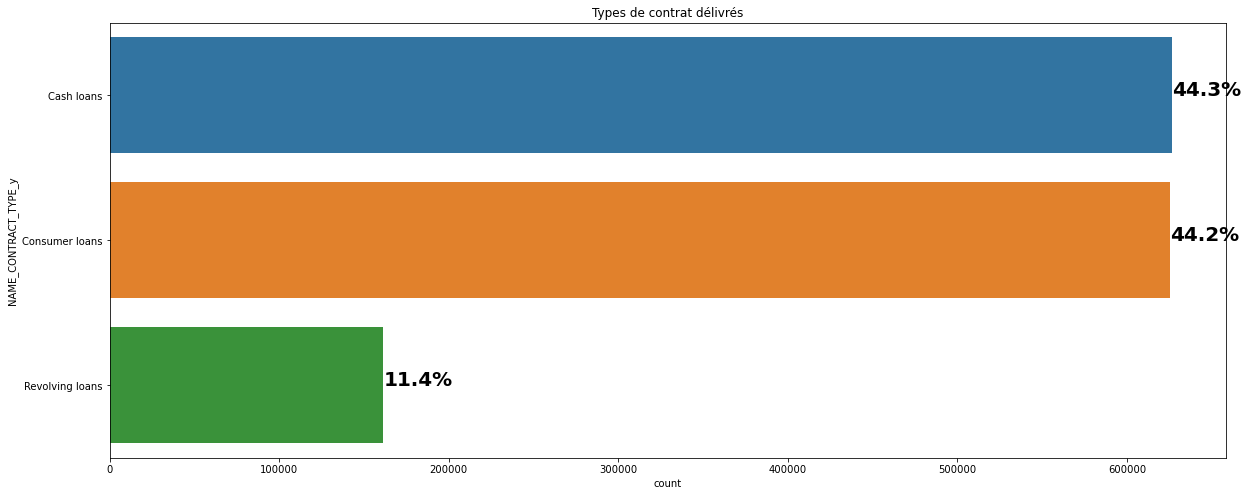

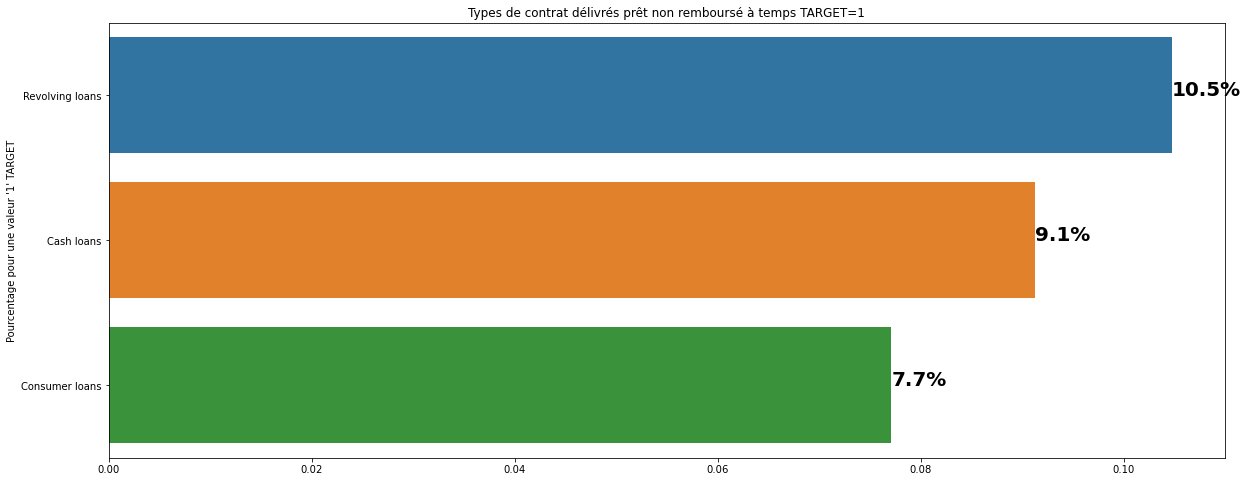

In [35]:
plot_stat(app_prev_train, 'NAME_CONTRACT_TYPE_y',"Types de contrat délivrés")

plot_percent_target1(app_prev_train, 'NAME_CONTRACT_TYPE_y',"Types de contrat délivrés prêt non remboursé à temps TARGET=1")

On constate que les prêts trésoreries et consomations sont majoritaire représentant chacune près de 44 % des clients suivi des prêts renouvelables près de 11 % .
La catégorie prêts renouvelable, bien que représentant 11.4 %, a le taux le plus élevé de non-remboursement du prêt inférieur à 11% suivi du prêt de trésoreries et à la consomation inférieur à 10 %.

#### Distribution d'un impact possible entre la Distribution de l’état du contrat

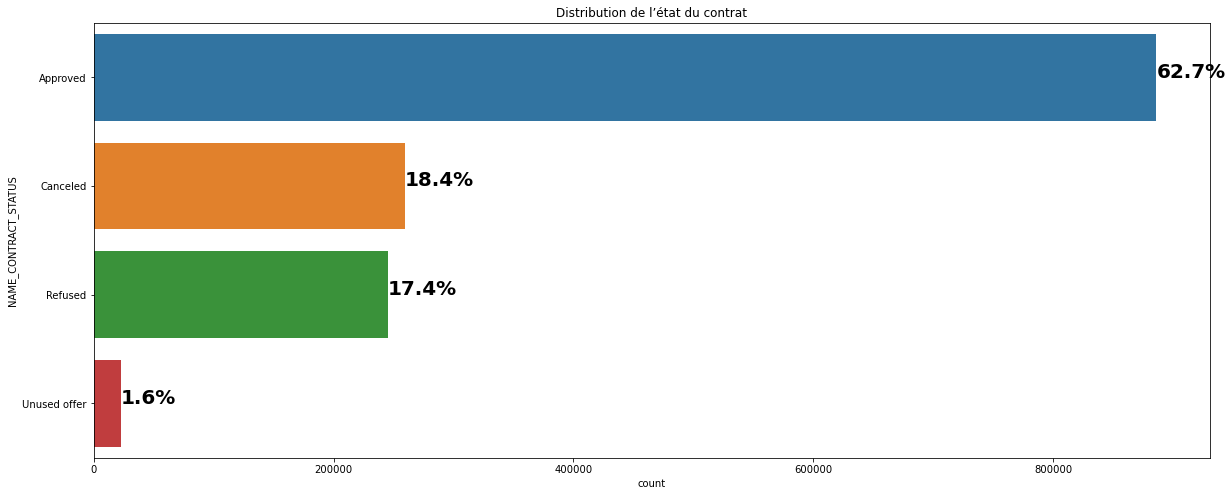

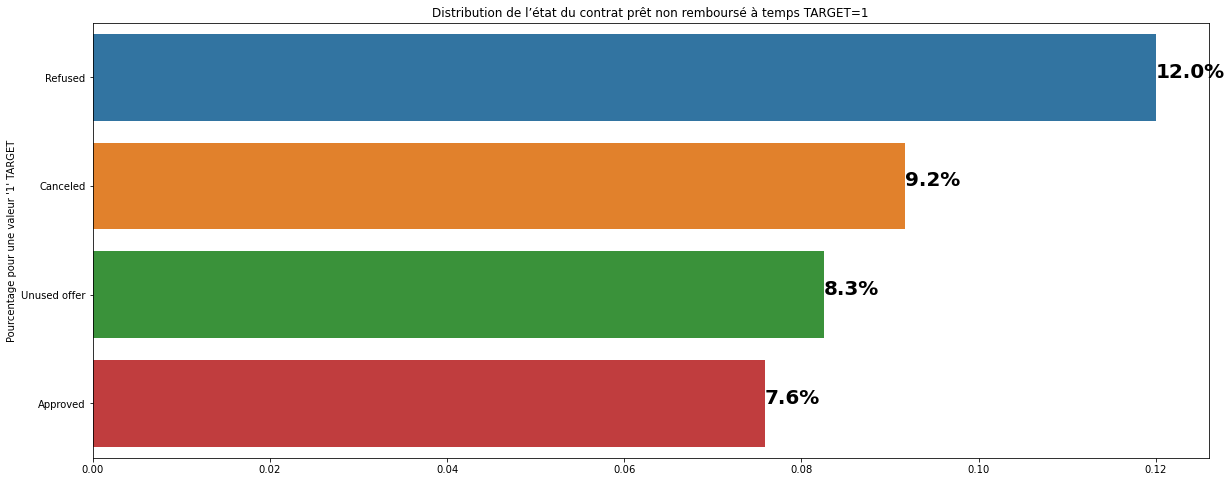

In [36]:
plot_stat(app_prev_train, 'NAME_CONTRACT_STATUS',"Distribution de l’état du contrat")

plot_percent_target1(app_prev_train, 'NAME_CONTRACT_STATUS',"Distribution de l’état du contrat prêt non remboursé à temps TARGET=1")

On constate que les contrats acceptés sont majoritaire représentant près de 63 % des clients suivi des contrats annulés et refusés représentant chacun 18 % des clients et pour finir les contrats offre inutilisée représentant moins de 2%.
La catégorie contrats refusé, bien que représentant 17.4 %, a le taux le plus élevé de non-remboursement du prêt représentant à 12% suivi des contrats annulés, offre inutilisé et approuvé inférieur à 10 %.

#### Distribution d'un impact possible entre la distribution des types de paiement

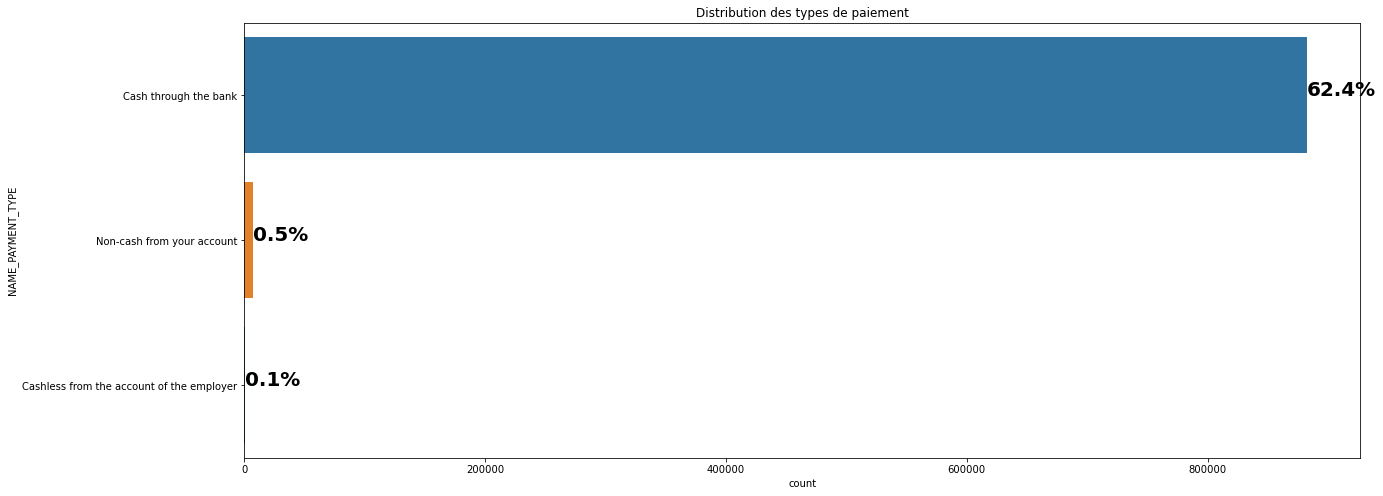

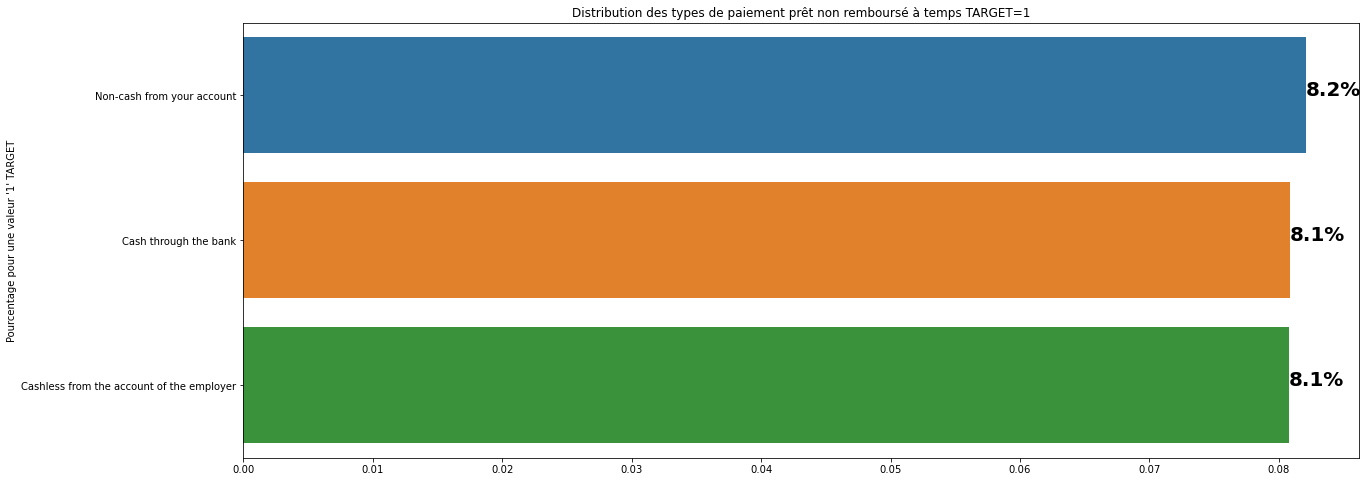

In [37]:
plot_stat(app_prev_train, 'NAME_PAYMENT_TYPE',"Distribution des types de paiement")

plot_percent_target1(app_prev_train, 'NAME_PAYMENT_TYPE',"Distribution des types de paiement prêt non remboursé à temps TARGET=1")

Le mode de paiement se fait majoritairement en Cash via la banque. Le remboursement du crédit en cas de défaillance (Target='1') ne se dintingue sur aucun type de paiement, l'égalité est quasi parfaite.

#### Distribution d'un impact possible entre la distribution type de client

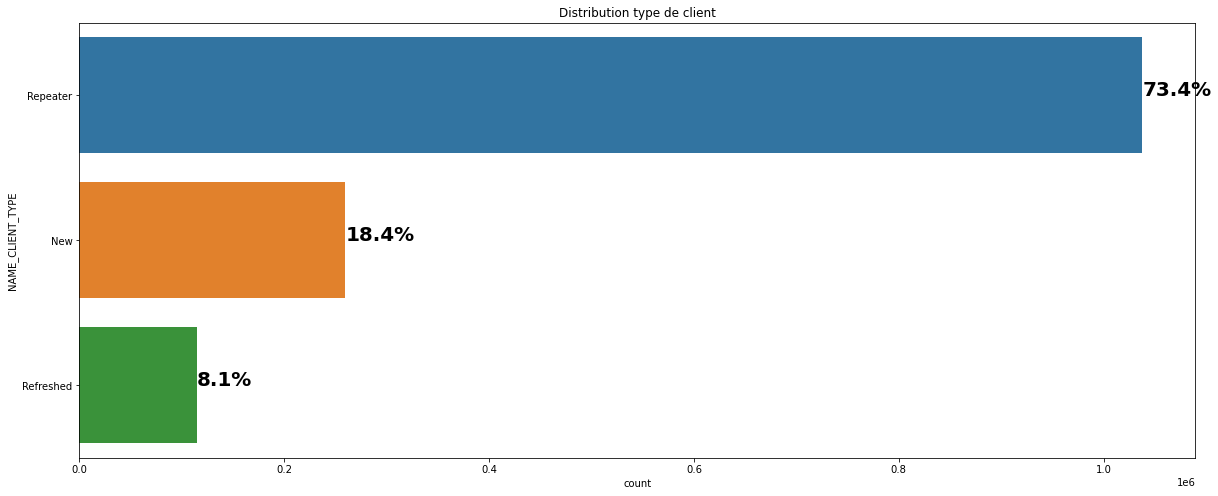

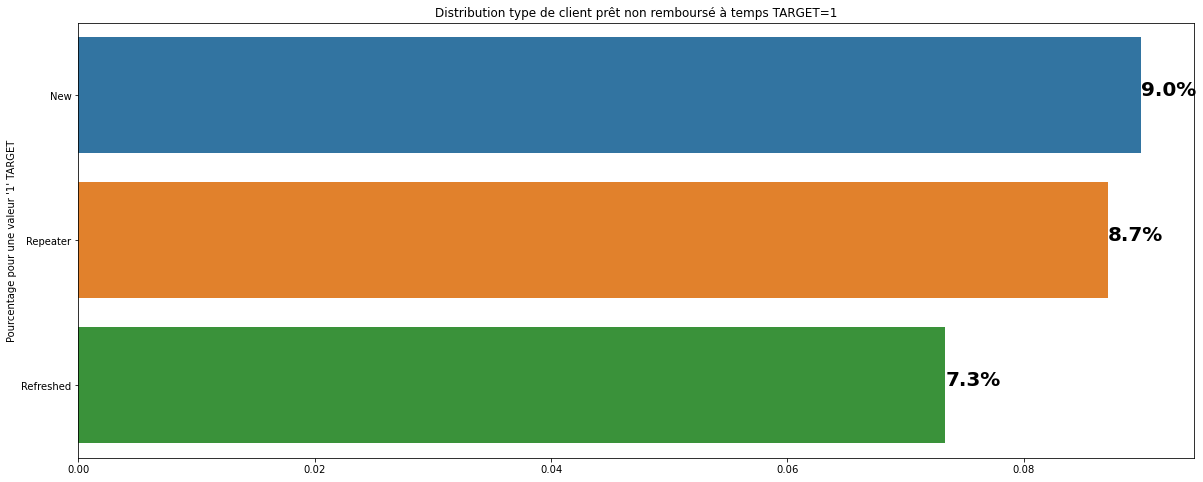

In [38]:
plot_stat(app_prev_train, 'NAME_CLIENT_TYPE',"Distribution type de client")

plot_percent_target1(app_prev_train, 'NAME_CLIENT_TYPE',"Distribution type de client prêt non remboursé à temps TARGET=1")

Les types de clients sont majoritairement des anciens clients. Le remboursement du crédit en cas de défaillance (Target='1') se dintingue sur les nouveaux et anciens clients représentant chacun prés de 9 % prés non remboursé à temps, les clients disponible pour un prêt représentent 7.3%.

### Fusion et agrégations ( assemblage) des données

Indispensable d'avoir une réflexion et une étape d'agrégation des données. Des informations complémentaires aux principaux fichiers peuvent en effet avoir un impact dans nos modélisations. Voyons comment traiter l'ensemble des jeux de données.

#### Créer un jeu de données avec l’application de fusion train / test

In [39]:
data = app_train.append(app_test)

Les deux jeux de données ont exactement le même format avec une seule différence, la TARGET dispo dans le train.

In [40]:
print('Train:' + str(app_train.shape))
print('Test:' + str(app_test.shape))
print('>>> Data:' + str(data.shape))

Train:(307511, 123)
Test:(48744, 122)
>>> Data:(356255, 123)


#### Vérifions le nombre de valeur manquante dans la TARGET

In [41]:
data.TARGET.isna().sum()

48744

Cela correspond bien au nombre de ligne Test qui ne comporte pas de TARGET.

In [42]:
sum(data.SK_ID_CURR[data.TARGET.isna()] == app_test.SK_ID_CURR)

48744

In [43]:
sum(data.SK_ID_CURR.isin(app_test.SK_ID_CURR)) == len(app_test)

True

#### Créer un jeu de données avec data et bureau

A partir du fichier bureau.csv, il est possible d'extraire un historique sur les précédents crédits enregistrés par les clients. Il peut donc être intéressant d'enrichir l'échantillon avec ce type de données.

In [44]:
display(bureau.shape)

(1716428, 17)

Calcul du nombre total des précédents crédits pris par chaque client. Ce type d'information viendra enrichir l'échantillon de travail.

##### Nombre total de crédits précédents pris par chaque client

In [45]:
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()

,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


##### Fusionner cette nouvelle colonne dans notre data

In [46]:
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 124)

#### Créer un jeu de données avec data et bureau_balance

In [47]:
bureau_balance.shape

(27299925, 3)

##### Soldes mensuels moyens des crédits précédents dans l’agence d’évaluation du crédit

In [48]:
bureau_bal_mean = bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                                                                {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean.head()

,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [49]:
bureau_full = bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


(1716428, 17)

In [50]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape

(305811, 14)

##### Fusionner toutes ces fonctionnalités avec notre data

In [51]:
data = data.merge(bureau_mean, on='SK_ID_CURR', how='left')
data.shape

(356255, 137)

Notons l'enrichissement avec 13 nouvelles features, créées et ajoutées à notre ensemble de données application train/test appelé data.

#### Vérification des valeurs de 'SK_ID_CURR' entre data et previous_application

In [52]:
display(previous_application.head())
display(previous_application.shape)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,NaN,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,NaN,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,NaN,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 37)

In [53]:
len(previous_application.SK_ID_CURR.isin(data.SK_ID_CURR)) == len(previous_application)

True

Comme précédemment, commençons par quantifier le nombre de demandes précédentes des clients au crédit immobilier et ajoutons cette données à l'échantillon.

##### Nombre de demandes antérieures des clients à Crédit-logement

In [54]:
previous_application_counts = previous_application.groupby('SK_ID_CURR', as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()

,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


##### Fusionner cette nouvelle colonne dans notre data

In [55]:
data = data.merge(previous_application_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 138)

#### vérifier credit_card_balance

In [56]:
display(credit_card_balance.head())
display(credit_card_balance.shape)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,...,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,...,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


(3840312, 23)

In [57]:
credit_card_balance.drop('SK_ID_CURR', axis=1, inplace=True)

In [58]:
credit_card_balance_mean = credit_card_balance.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
credit_card_balance_mean.shape

(104307, 21)

##### Fusionner credit_card_balance_mean avec previous_application

In [59]:
previous_application = previous_application.merge(credit_card_balance_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 57)

#### vérifier installments_payments

In [60]:
display(installments_payments.head())
display(installments_payments.shape)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


(13605401, 8)

In [61]:
installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)

In [62]:
install_pay_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
install_pay_mean.shape

(997752, 7)

##### Fusionner install_pay_mean avec previous_application

In [63]:
previous_application = previous_application.merge(install_pay_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 63)

#### Vérifier POS_CASH_balance

In [64]:
display(POS_CASH_balance.head())
display(POS_CASH_balance.shape)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


(10001358, 8)

In [65]:
POS_CASH_balance.drop('SK_ID_CURR', axis=1, inplace=True)

In [66]:
POS_mean = installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
POS_mean.shape

(997752, 7)

##### Fusionner POS_mean avec previous_application

In [67]:
previous_application = previous_application.merge(POS_mean, on='SK_ID_PREV', how='left')
previous_application.shape

(1670214, 69)

#### Retour sur previous_application pour assembler les lignes d'observation selon 'SK_ID_CURR'

In [68]:
display(previous_application.head())
display(previous_application.shape)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,INSTALL_MEAN_DAYS_INSTALMENT,INSTALL_MEAN_DAYS_ENTRY_PAYMENT,INSTALL_MEAN_AMT_INSTALMENT,INSTALL_MEAN_AMT_PAYMENT,POS_MEAN_NUM_INSTALMENT_VERSION,POS_MEAN_NUM_INSTALMENT_NUMBER,POS_MEAN_DAYS_INSTALMENT,POS_MEAN_DAYS_ENTRY_PAYMENT,POS_MEAN_AMT_INSTALMENT,POS_MEAN_AMT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,-42.0,-42.000000,17284.275000,17284.275000,2.000000,1.0,-42.0,-42.000000,17284.275000,17284.275000
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,-74.0,-83.200000,25188.615000,25188.615000,1.000000,3.0,-74.0,-83.200000,25188.615000,25188.615000
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,-151.0,-159.222222,15060.735000,15060.735000,1.000000,5.0,-151.0,-159.222222,15060.735000,15060.735000
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,-332.0,-339.090909,51193.943182,51193.943182,1.090909,6.0,-332.0,-339.090909,51193.943182,51193.943182
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 69)

In [69]:
prev_appl_mean = previous_application.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'}, inplace=True)
prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis=1)

In [70]:
display(prev_appl_mean.head())
display(prev_appl_mean.shape)

,SK_ID_CURR,PREV_APPL_MEAN_AMT_ANNUITY,PREV_APPL_MEAN_AMT_APPLICATION,PREV_APPL_MEAN_AMT_CREDIT,PREV_APPL_MEAN_AMT_DOWN_PAYMENT,PREV_APPL_MEAN_AMT_GOODS_PRICE,PREV_APPL_MEAN_HOUR_APPR_PROCESS_START,PREV_APPL_MEAN_NFLAG_LAST_APPL_IN_DAY,PREV_APPL_MEAN_RATE_DOWN_PAYMENT,PREV_APPL_MEAN_RATE_INTEREST_PRIMARY,...,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100001,3951.000,24835.50,23787.00,2520.0,24835.5,13.000000,1.0,0.104326,NaN,...,-1664.000000,-1679.500000,7312.725000,7312.725000,1.250000,2.500000,-1664.000000,-1679.500000,7312.725000,7312.725000
1,100002,9251.775,179055.00,179055.00,0.0,179055.0,9.000000,1.0,0.000000,NaN,...,-295.000000,-315.421053,11559.247105,11559.247105,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
2,100003,56553.990,435436.50,484191.00,3442.5,435436.5,14.666667,1.0,0.050030,NaN,...,-1164.333333,-1171.781746,78558.479286,78558.479286,1.047619,4.666667,-1164.333333,-1171.781746,78558.479286,78558.479286
3,100004,5357.250,24282.00,20106.00,4860.0,24282.0,5.000000,1.0,0.212008,NaN,...,-754.000000,-761.666667,7096.155000,7096.155000,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
4,100005,4813.200,22308.75,20076.75,4464.0,44617.5,10.500000,1.0,0.108964,NaN,...,-586.000000,-609.555556,6240.205000,6240.205000,1.111111,5.000000,-586.000000,-609.555556,6240.205000,6240.205000


(338857, 52)

##### Rappel

In [71]:
print('data shape', data.shape)

data shape (356255, 138)


##### Dernière fusion avec notre data

In [72]:
data = data.merge(prev_appl_mean, on='SK_ID_CURR', how='left')

##### Index data ('SK_ID_CURR', inplace=True)

In [73]:
display(data.head())
display(data.shape)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-295.000000,-315.421053,11559.247105,11559.247105,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1164.333333,-1171.781746,78558.479286,78558.479286,1.047619,4.666667,-1164.333333,-1171.781746,78558.479286,78558.479286
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-754.000000,-761.666667,7096.155000,7096.155000,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-260.666667,-285.966667,241944.225000,241944.225000,1.400000,3.166667,-260.666667,-285.966667,241944.225000,241944.225000
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-1087.881319,-1090.768539,12122.995738,11671.540210,1.129412,6.843956,-1087.881319,-1090.768539,12122.995738,11671.540210


(356255, 189)

50 nouvelles variables ont été ajoutées à l'échantillon suite aux opérations de fusion.

### Ingénieurie fonctionnelle

Il peut être pertinent d'enrichir l'échantillon par un ajout de variables spécifiques à la problématique métier. N'étant pas spécialisé dans l'expertise des crédits, on pourra mener les modélisations avec une étape de features selection qui déterminera la pertinence de ces variables, ainsi que toutes les autres variables de l'échantillon.

#### 3 variables fonctionnelles extraites des précédentes étapes

Pour rappel, les étapes précédentes consistaient uniquement à établir des liens entre nos fichiers, des fusions de table dans le but d'enrichir l'échantillon de travail. Ceci étant, avant de procéder au fusion des éléments, on a pu facilement extraire 3 variables de moyenne et de comptage.
- PREVIOUS_LOANS_COUNT de bureau.csv: Nombre total des précédents crédits pris par chaque client
- MONTHS_BALANCE_MEAN de bureau_balance.csv: Solde moyen mensuel des précédents crédits 
- PREVIOUS_APPLICATION_COUNT de previous_application.csv: Nombre de demandes antérieures des clients au crédit immobilier

### Création de 4 nouvelles variables métiers

Sans être expert en crédit bancaire, on peut assez facilement apporter quelques ratios explicatifs. D'autant plus qu'une veille parallèle permet de mieux comprendre les enjeux attendus. Voyons ci-dessous quelles variables est-il pertinent d'intégrer.
- CREDIT_INCOME_PERCENT: Pourcentage du montant du crédit par rapport au revenu d'un client
- ANNUITY_INCOME_PERCENT: Pourcentage de la rente de prêt par rapport au revenu d'un client
- CREDIT_TERM: Durée du paiement en mois
- DAYS_EMPLOYED_PERCENT: Pourcentage des jours employés par rapport à l'âge du client

#### Avant

In [74]:
data.shape

(356255, 189)

In [75]:
data['CREDIT_INCOME_PERCENT'] = data['AMT_CREDIT'] / data['AMT_INCOME_TOTAL']
data['ANNUITY_INCOME_PERCENT'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['CREDIT_TERM'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']
data['DAYS_EMPLOYED_PERCENT'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']

#### Après

In [76]:
data.shape

(356255, 193)

### Nombre de chaque type de colonne données data

In [77]:
data.dtypes.value_counts()

float64    137
int64       39
object      16
bool         1
dtype: int64

## TRANSFORMATION DU JEU DE DONNEES

### Encodage des jeux de données data par étiquettes

#### Créer un objet encodeur d’étiquette

In [78]:
le = LabelEncoder()
count = 0

#### Parcourir les colonnes

In [79]:
for col in data:
    # Si 2 valeurs uniques ou moins
    if data.loc[:,col].dtype == 'object' and len(list(data.loc[:,col].unique())) <= 2:
        # Apprentissage sur les données data
        le.fit(data.loc[:,col])
        # Transformer les données data
        data.loc[:,col] = le.transform(data.loc[:,col])

        count += 1
            
print('%d colonnes ont été codées.' % count)

3 colonnes ont été codées.


In [80]:
for col in data:
    # Si 2 valeurs uniques ou moins
    if data.loc[:,col].dtype == 'bool' and len(list(data.loc[:,col].unique())) <= 2:
        # Apprentissage sur les données data
        le.fit(data.loc[:,col])
        # Transformer les données data
        data.loc[:,col] = le.transform(data.loc[:,col])

        count += 1
            
print('%d colonnes ont été codées.' % count)

4 colonnes ont été codées.


#### Nombre de chaque type de colonne données data après encodage étiquette

In [81]:
data.dtypes.value_counts()

float64    137
int64       40
object      13
int32        3
dtype: int64

In [82]:
print("Nombre de ligne et de colonne du jeu de données data: ", data.shape)

Nombre de ligne et de colonne du jeu de données data:  (356255, 193)


### Encodage des jeux de données data à chaud

In [83]:
data = pd.get_dummies(data)

#### Nombre de chaque type de colonne données data après encodage à chaud

In [84]:
data.dtypes.value_counts()

float64    137
uint8      132
int64       40
int32        3
dtype: int64

In [85]:
print("Nombre de ligne et de colonne du jeu de données data: ", data.shape)

Nombre de ligne et de colonne du jeu de données data:  (356255, 312)


### Imputation des valeurs manquantes

L'une des approches les plus simples consiste à remplacer les NaN par la Médiane (ou Moyenne) pour les variables correspondantes.

In [86]:
print('Valeurs manquantes dans le train data: ', sum(data.isnull().sum()))

Valeurs manquantes dans le train data:  17870070


In [87]:
imputer = SimpleImputer(strategy='median')
data.iloc[:,:] = imputer.fit_transform(data)

#### Vérifier l’étape d’imputation

<AxesSubplot:>

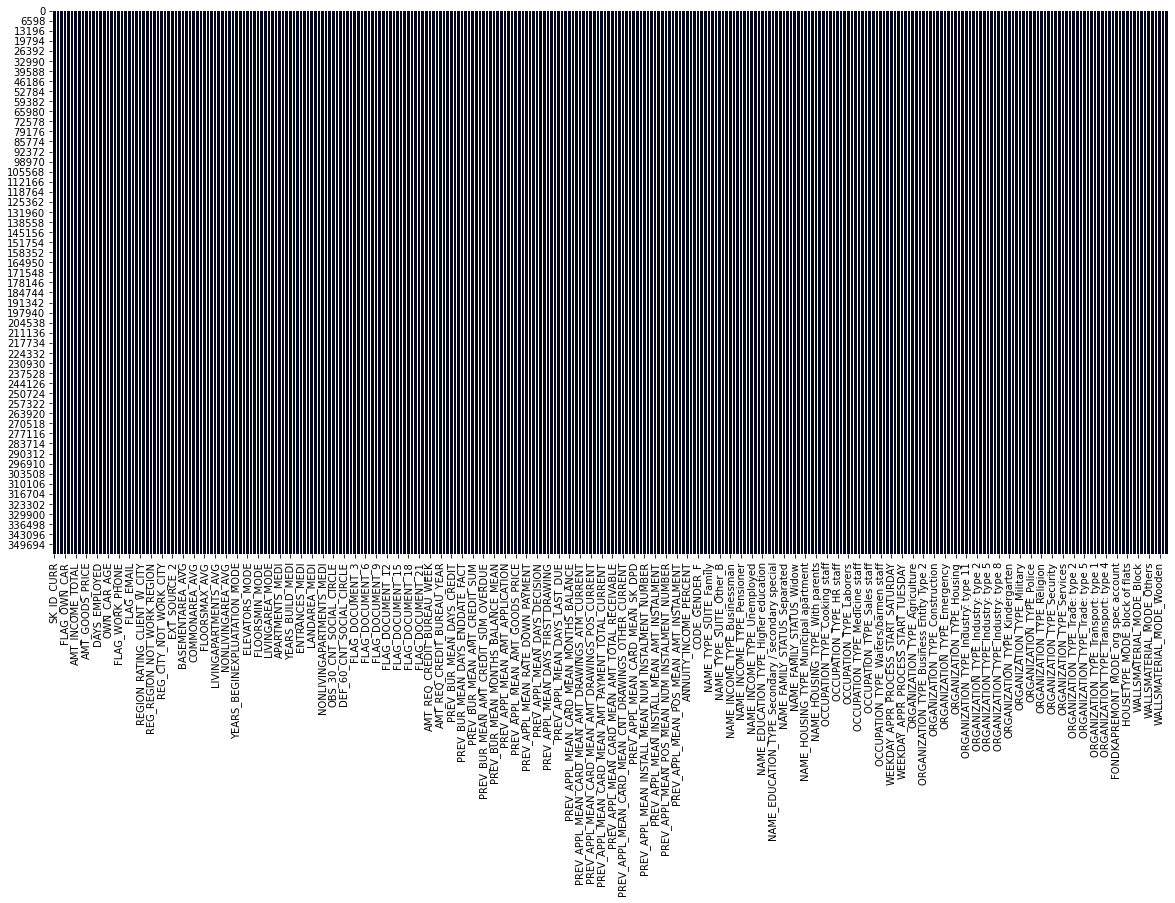

In [88]:
plt.figure(figsize=(20,10))
sb.heatmap(data.isna(), cbar=False)

### Standardisation des données

In [89]:
data.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002.0,1.0,0.0,0.0,1.0,0.0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,100003.0,0.0,0.0,0.0,0.0,0.0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,100004.0,0.0,1.0,1.0,1.0,0.0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006.0,0.0,0.0,0.0,1.0,0.0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007.0,0.0,0.0,0.0,1.0,0.0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,100008.0,0.0,0.0,0.0,1.0,0.0,99000.0,490495.5,27517.5,454500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,100009.0,0.0,0.0,1.0,1.0,1.0,171000.0,1560726.0,41301.0,1395000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,100010.0,0.0,0.0,1.0,1.0,0.0,360000.0,1530000.0,42075.0,1530000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,100011.0,0.0,0.0,0.0,1.0,0.0,112500.0,1019610.0,33826.5,913500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,100012.0,0.0,1.0,0.0,1.0,0.0,135000.0,405000.0,20250.0,405000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


L'échantillon rassemble des variables de grandeur différente, par exemple les salaires vs le nombre d'enfants.

#### Adapter scaler à nos données data

In [90]:
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data)
scaled = scaler.transform(data)

#### Afin de conserver nos noms de colonnes, nous incluons scaled_values à nos trames de données data

In [91]:
data = pd.DataFrame(scaled, index=data.index, columns=data.columns)

In [92]:
data.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.000003,1.0,0.0,0.0,1.0,0.00,0.001512,0.090287,0.090032,0.077441,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0.000006,0.0,0.0,0.0,0.0,0.00,0.002089,0.311736,0.132924,0.271605,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000008,0.0,1.0,1.0,1.0,0.00,0.000358,0.022472,0.020025,0.023569,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000014,0.0,0.0,0.0,1.0,0.00,0.000935,0.066837,0.109477,0.063973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000017,0.0,0.0,0.0,1.0,0.00,0.000819,0.116854,0.078975,0.117845,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.000020,0.0,0.0,0.0,1.0,0.00,0.000627,0.111235,0.101018,0.103255,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000022,0.0,0.0,1.0,1.0,0.05,0.001243,0.378458,0.154774,0.337823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000025,0.0,0.0,1.0,1.0,0.00,0.002858,0.370787,0.157792,0.371493,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.000028,0.0,0.0,0.0,1.0,0.00,0.000742,0.243348,0.125623,0.217733,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000031,0.0,1.0,0.0,1.0,0.00,0.000935,0.089888,0.072675,0.090909,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Après avoir standardiser mon jeu de données, il n’y a plus de variables de grandeur différentes.

In [93]:
compression_opts = dict(method='zip', archive_name='data.csv')
data.to_csv('data.zip', index=True, compression=compression_opts)

### Equilibrage de la variable target SMOTE

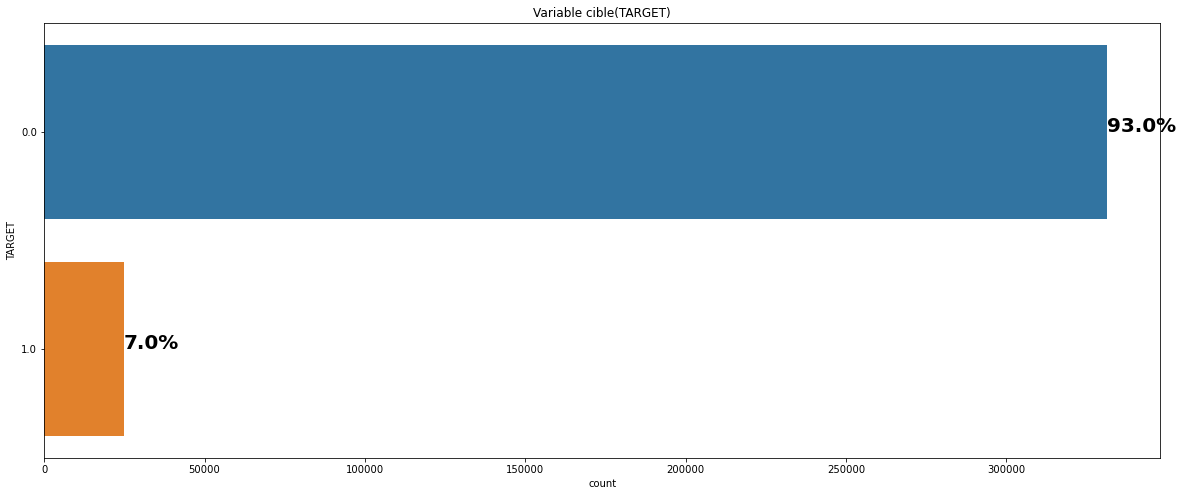

In [94]:
plot_stat(data,"TARGET","Variable cible(TARGET)")

In [95]:
X = data.drop('TARGET', axis=1)
y = data['TARGET']

In [96]:
sm = SMOTE(random_state=42)

X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Forme de X avant SMOTE: {X.shape}
Forme de X après SMOTE: {X_sm.shape}''')

print('\nSolde des classes prêt remboursé pas à temps et à temps (%):')
y_sm.value_counts(normalize=True) * 100

Forme de X avant SMOTE: (356255, 311)
Forme de X après SMOTE: (662860, 311)

Solde des classes prêt remboursé pas à temps et à temps (%):


1.0    50.0
0.0    50.0
Name: TARGET, dtype: float64

On constate 565 372 points de données au lieu de 307 511, et l'équilibre de classe est parfait - 50:50.

In [97]:
data=pd.concat([X_sm,y_sm], axis=1)

In [98]:
data.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,0.000003,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256702,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,0.000006,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045506,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.000008,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.135340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000014,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000017,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.393191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Vérifier l'équilibrage de la TARGET

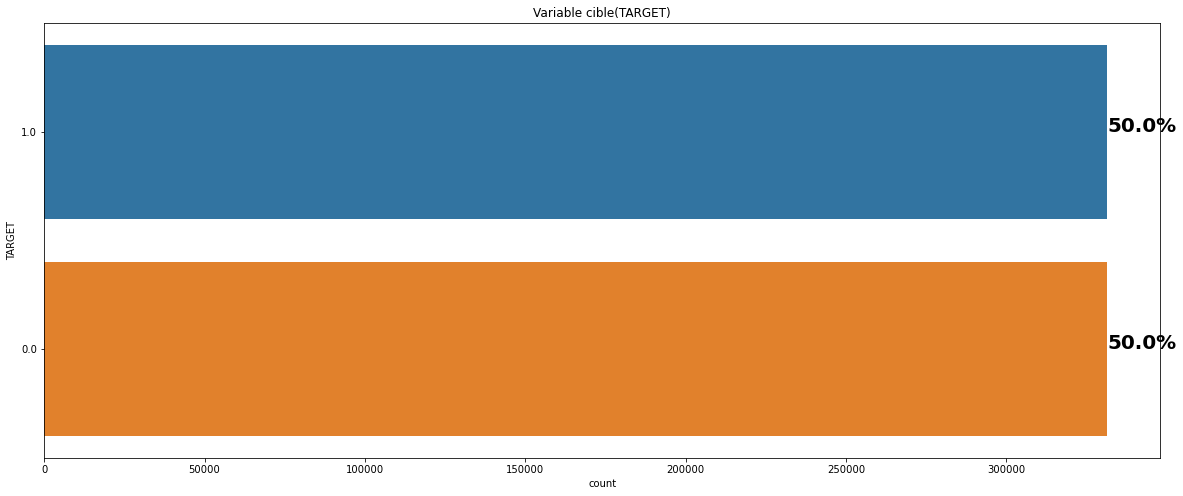

In [99]:
plot_stat(data,"TARGET","Variable cible(TARGET)")

### Vérifier les corrélations du jeu de données en fonction de la TARGET

Je vais verifier les 30 meilleurs corrélations avec la TARGET.

In [100]:
print('Correlations les plus positives:\n', data.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Correlations les plus négatives:\n', data.corr()['TARGET'].sort_values().head(15))

Correlations les plus positives:
 CODE_GENDER_M                                        0.094901
PREV_BUR_MEAN_DAYS_ENDDATE_FACT                      0.095990
DAYS_ID_PUBLISH                                      0.097661
PREV_APPL_MEAN_DAYS_DECISION                         0.102629
FLAG_DOCUMENT_3                                      0.107680
REGION_RATING_CLIENT                                 0.123151
DAYS_LAST_PHONE_CHANGE                               0.124920
NAME_INCOME_TYPE_Working                             0.125965
REGION_RATING_CLIENT_W_CITY                          0.128619
PREV_BUR_MEAN_DAYS_CREDIT_UPDATE                     0.130468
NAME_EDUCATION_TYPE_Secondary / secondary special    0.132558
DAYS_EMPLOYED                                        0.146549
DAYS_BIRTH                                           0.149723
PREV_BUR_MEAN_DAYS_CREDIT                            0.168499
TARGET                                               1.000000
Name: TARGET, dtype: float64
-------

### Sélectionner les 24 variables les plus corrélés avec la TARGET

In [101]:
Var_cor = data[['TARGET','EXT_SOURCE_2', 'EXT_SOURCE_3', 'EXT_SOURCE_1', 'PREV_BUR_MEAN_DAYS_CREDIT',
                'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE_Secondary / secondary special',
                'DAYS_EMPLOYED_PERCENT', 'NAME_EDUCATION_TYPE_Higher education', 'PREV_BUR_MEAN_DAYS_CREDIT_UPDATE',
                'REGION_RATING_CLIENT_W_CITY', 'NAME_INCOME_TYPE_Working', 'DAYS_LAST_PHONE_CHANGE',
                'REGION_RATING_CLIENT', 'FLAG_DOCUMENT_3', 'PREV_APPL_MEAN_DAYS_DECISION','CODE_GENDER_M',
                'DAYS_ID_PUBLISH', 'EMERGENCYSTATE_MODE_No',
                'ELEVATORS_AVG','ELEVATORS_MEDI','FLOORSMAX_AVG','CODE_GENDER_F', 
                'PREV_BUR_MEAN_DAYS_ENDDATE_FACT']]

### Carte thermique des corrélations les plus corrélés à la TARGET

Avant d'étudier la carte thermique des corrélations voici la description sous forme d'abaque:
- 00 à 0.19 “très faible” , 
- 0.20 à 0.39 “faible”, 
- 0.40 à 0.59 “modéré”, 
- 0.60 à 0.79 “fort”, 
- 0.80 à 1.0 “très fort”.

Text(0.5, 1.0, 'Carte thermique de corrélations Var_cor')

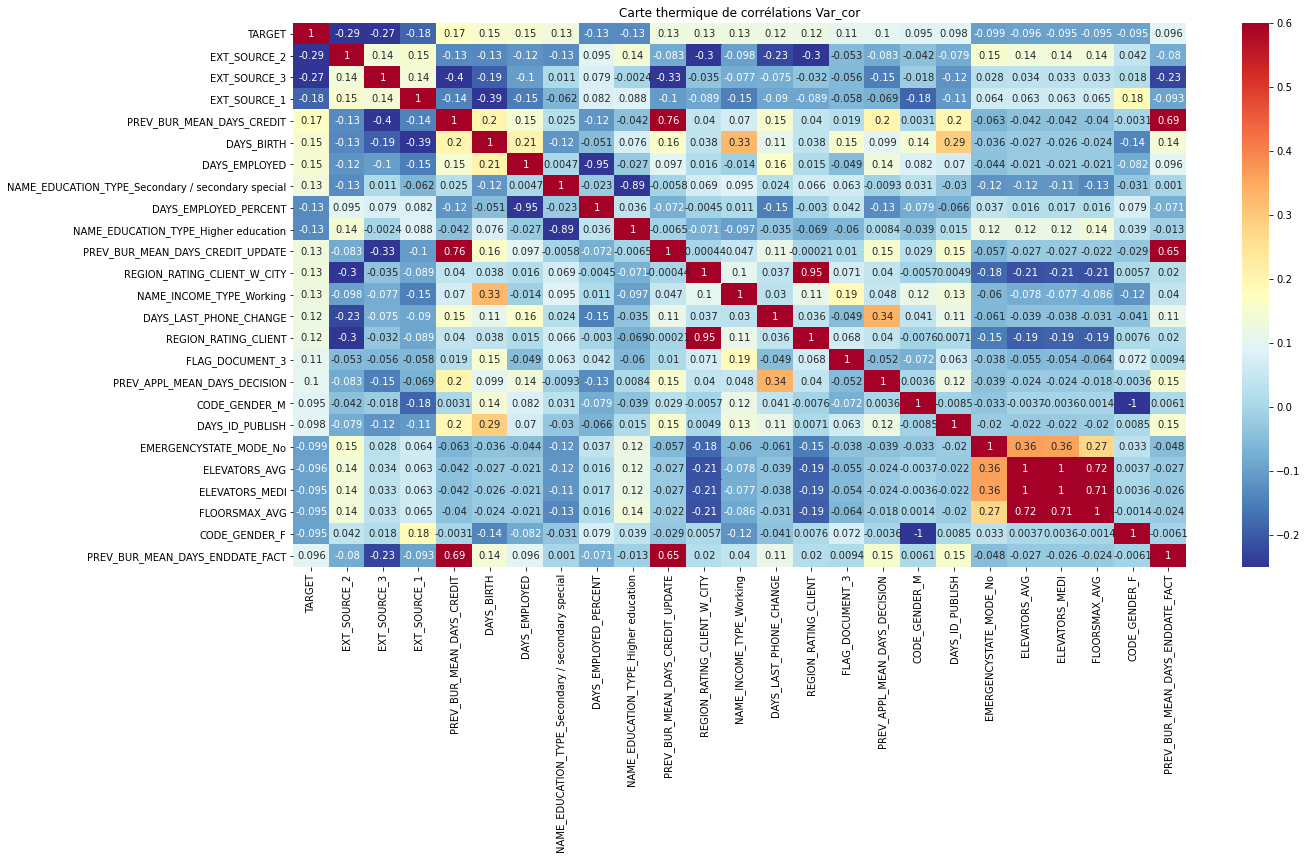

In [102]:
plt.figure(figsize = (20,10))
sb.heatmap(Var_cor.corr(),
            cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6,
           )
plt.title('Carte thermique de corrélations Var_cor')

On constate qu'il y a de très forte corrélation, j'en dédui que:
- DAYS_EMPLOYED=DAYS_EMPLOYED_PERCENT
- NAME_EDUCATION_TYPE_Secondary / secondary special=NAME_EDUCATION_TYPE_Higher education
- REGION_RATING_CLIENT_W_CITY=REGION_RATING_CLIENT
- CODE_GENDER_M=CODE_GENDER_F
- ELEVATORS_MEDI=ELEVATORS_AVG

### Suppression de 5 variables dans notre nouveau jeu de données

In [103]:
Var_imp = Var_cor.drop(columns=['DAYS_EMPLOYED_PERCENT', 'NAME_EDUCATION_TYPE_Higher education', 'REGION_RATING_CLIENT',
                                'CODE_GENDER_F','ELEVATORS_AVG'])

In [104]:
# Enregistrer Var_imp
compression_opts = dict(method='zip', archive_name='Var_imp.csv')
Var_imp.to_csv('Var_imp.zip', index=True, compression=compression_opts)

## COMPARAISON ET SYNTHESE DES RESULTATS POUR LES MODELES UTILISES

La modélisation sera faite sur un Notebook Google (ou Colaboratory)Colab pour pouvoir utiliser un GPU.
Nous implémenterons les algorithmes Catboost, LightGBM & XGBoost.